In [1]:
utf8::utf8_print('\U0001f6a7 work in progress \U0001f6a7')

[1] "🚧​ work in progress 🚧​"


# Comparison between variant annotation databases

**Goal:** This notebook is directly linked to [`doc/biblio/variant_annotation_databases.md`](https://github.com/ElsaB/impact-annotator/blob/master/doc/biblio/variant_annotation_databases.md) which compares and describes different variant annotation databases. The aim of this notebook is to compare the annotations of some of the databases studied in the markdown with OncoKB annotations.

We will study different databases available online and compare them with OncoKB:
* [CanDL](https://github.com/ElsaB/impact-annotator/blob/master/doc/biblio/variant_annotation_databases.md#candl)
* [DoCM](https://github.com/ElsaB/impact-annotator/blob/master/doc/biblio/variant_annotation_databases.md#docm)
* [Precision Medicine Knowledgebase](https://github.com/ElsaB/impact-annotator/blob/master/doc/biblio/variant_annotation_databases.md#precision-medicine-knowledgebase) (couldn't finish)
* [CIViC](https://github.com/ElsaB/impact-annotator/blob/master/doc/biblio/variant_annotation_databases.md#civic)
* [Cancer Genome Interpreter](https://github.com/ElsaB/impact-annotator/blob/master/doc/biblio/variant_annotation_databases.md#cancer-genome-interpreter)

This notebook is divided in 7 parts:

* **1. CanDL**
* **2. DoCM**
* **3. Precision Medicine Knowledgebase**
* **4. CIViC**
* **5. Cancer Genome Interpreter**
* **6. Study the IMPACT variants repartition accross the databases**
* **7. Study shared genes**

The process to study the database `another_database` will always be the same and each section (from 1 to 5)
will be divided in the following subsections:
1. Get the raw dataframe `another_database`
2. Create keys to join the dataframe `impact` and `another_database`. Two verifications to do:
    1. every key in `another_database` has unique values
    2. every key in `impact` has an analoguous key in `another_database`
3. Compare `another_database` annotations with OncoKB annotations

The work presented here is "approximative" as we used a special tool to link our `impact` dataset with OncoKB (oncokb-annotator) while we're just trying here to link the other databases by hand, not always going into the most details to get every mutations.

***

In [2]:
source("../../../src/utils/custom_tools.R")
setup_environment("../../../src/utils")

In [3]:
impact <- read.table("../../../data/cleaned_IMPACT_mutations_180508.txt", sep = "\t", stringsAsFactors = FALSE, header = TRUE)
impact <- add_features("../../../data/", impact, oncokb = TRUE)

We will only work with the curated mutations:

In [4]:
impact <- impact[impact$confidence_class %in% c("AUTO_OK", "MANUAL_OK"),] # keep only the somatic mutations

In [5]:
impact$is_in_oncokb <- "no"
impact$is_in_oncokb[impact$oncogenic %in% c("Oncogenic", "Likely Oncogenic", "Predicted Oncogenic")] <- "yes"

## CanDL

### Get the raw data

Data downloaded from https://candl.osu.edu/download/full, 09/08/18 version.

In [6]:
candl <- read.table("../../../data/other_databases/candl-results-20180809100701.csv",
                    sep = ",", stringsAsFactors = FALSE, header = TRUE)

In [7]:
nrow(candl)
length(unique(candl$Gene))
colnames(candl)

[1] 1820

[1] 62

[1] "ID"                "Gene"              "Normal.AA"        
 [4] "Peptide.Position"  "Mutation.AA"       "Chromosome"       
 [7] "DNA.Position"      "Codon"             "Transcript"       
[10] "Gene.Strand"       "RNA.Position"      "Exon"             
[13] "Mutation.Codon"    "Cancer.Type"       "Level.of.Evidence"
[16] "PMIDs"

In [8]:
head(candl)

ID,Gene,Normal.AA,Peptide.Position,Mutation.AA,Chromosome,DNA.Position,Codon,Transcript,Gene.Strand,RNA.Position,Exon,Mutation.Codon,Cancer.Type,Level.of.Evidence,PMIDs
1,ABL1,T,212,R,9,133738234,ACG,uc004bzw.3,+,634,4,AGG,Chronic Myelocytic Leukemia,3,20519627
2,ABL1,T,212,R,9,133738235,ACG,uc004bzw.3,+,635,4,AGG,Chronic Myelocytic Leukemia,3,20519627
3,ABL1,T,212,R,9,133738236,ACG,uc004bzw.3,+,636,4,AGG,Chronic Myelocytic Leukemia,3,20519627
4,ABL1,G,250,E,9,133738348,GGG,uc004bzw.3,+,748,4,GAG,Chronic Myelocytic Leukemia,1,23190221
5,ABL1,G,250,E,9,133738349,GGG,uc004bzw.3,+,749,4,GAG,Chronic Myelocytic Leukemia,1,23190221
6,ABL1,G,250,E,9,133738350,GGG,uc004bzw.3,+,750,4,GAG,Chronic Myelocytic Leukemia,1,23190221


### Create keys to join the two dataframes and extract the features

We will join the database using the following keys: 
* `Hugo_Symbol`.`HGVSp_Short` for `impact`
* `Gene`.p.`Normal.AA` `Peptide.Position` `Mutation.AA` for `candl`

In [9]:
impact$candl_key <- paste0(impact$Hugo_Symbol, '.', impact$HGVSp_Short)
head(impact$candl_key)

[1] "TP53.p.T256P"   "PIK3R3.p.I298M" "ATR.p.R2431M"   "PDGFRA.p.L465M"
[5] "FBXW7."         "FBXW7.p.G61*"

In [10]:
candl$join_key <- paste0(candl$Gene, '.p.', candl$Normal.AA, candl$Peptide.Position, candl$Mutation.AA)
head(candl$join_key)

[1] "ABL1.p.T212R" "ABL1.p.T212R" "ABL1.p.T212R" "ABL1.p.G250E" "ABL1.p.G250E"
[6] "ABL1.p.G250E"

**Verification 1** The `join_key` are not unique:

In [11]:
length(unique(candl$join_key))
nrow(candl)

[1] 345

[1] 1820

Looking closer at the data, every key is repeated a few times because every DNA 3-bp codon creating the protein change is in the database.

In [12]:
# make them unique
candl <- unique(candl[, c("Gene", "Normal.AA", "Peptide.Position", "Mutation.AA", "Chromosome", "join_key")])

length(unique(candl$join_key))
nrow(candl)

[1] 345

[1] 345

**Verification 2** not every impact `candl_key` has an analoguous `join_key` in `candl`.

In [13]:
impact$is_in_candl <- "no"
impact$is_in_candl[impact$candl_key %in% candl$join_key] <- "yes"

### Results

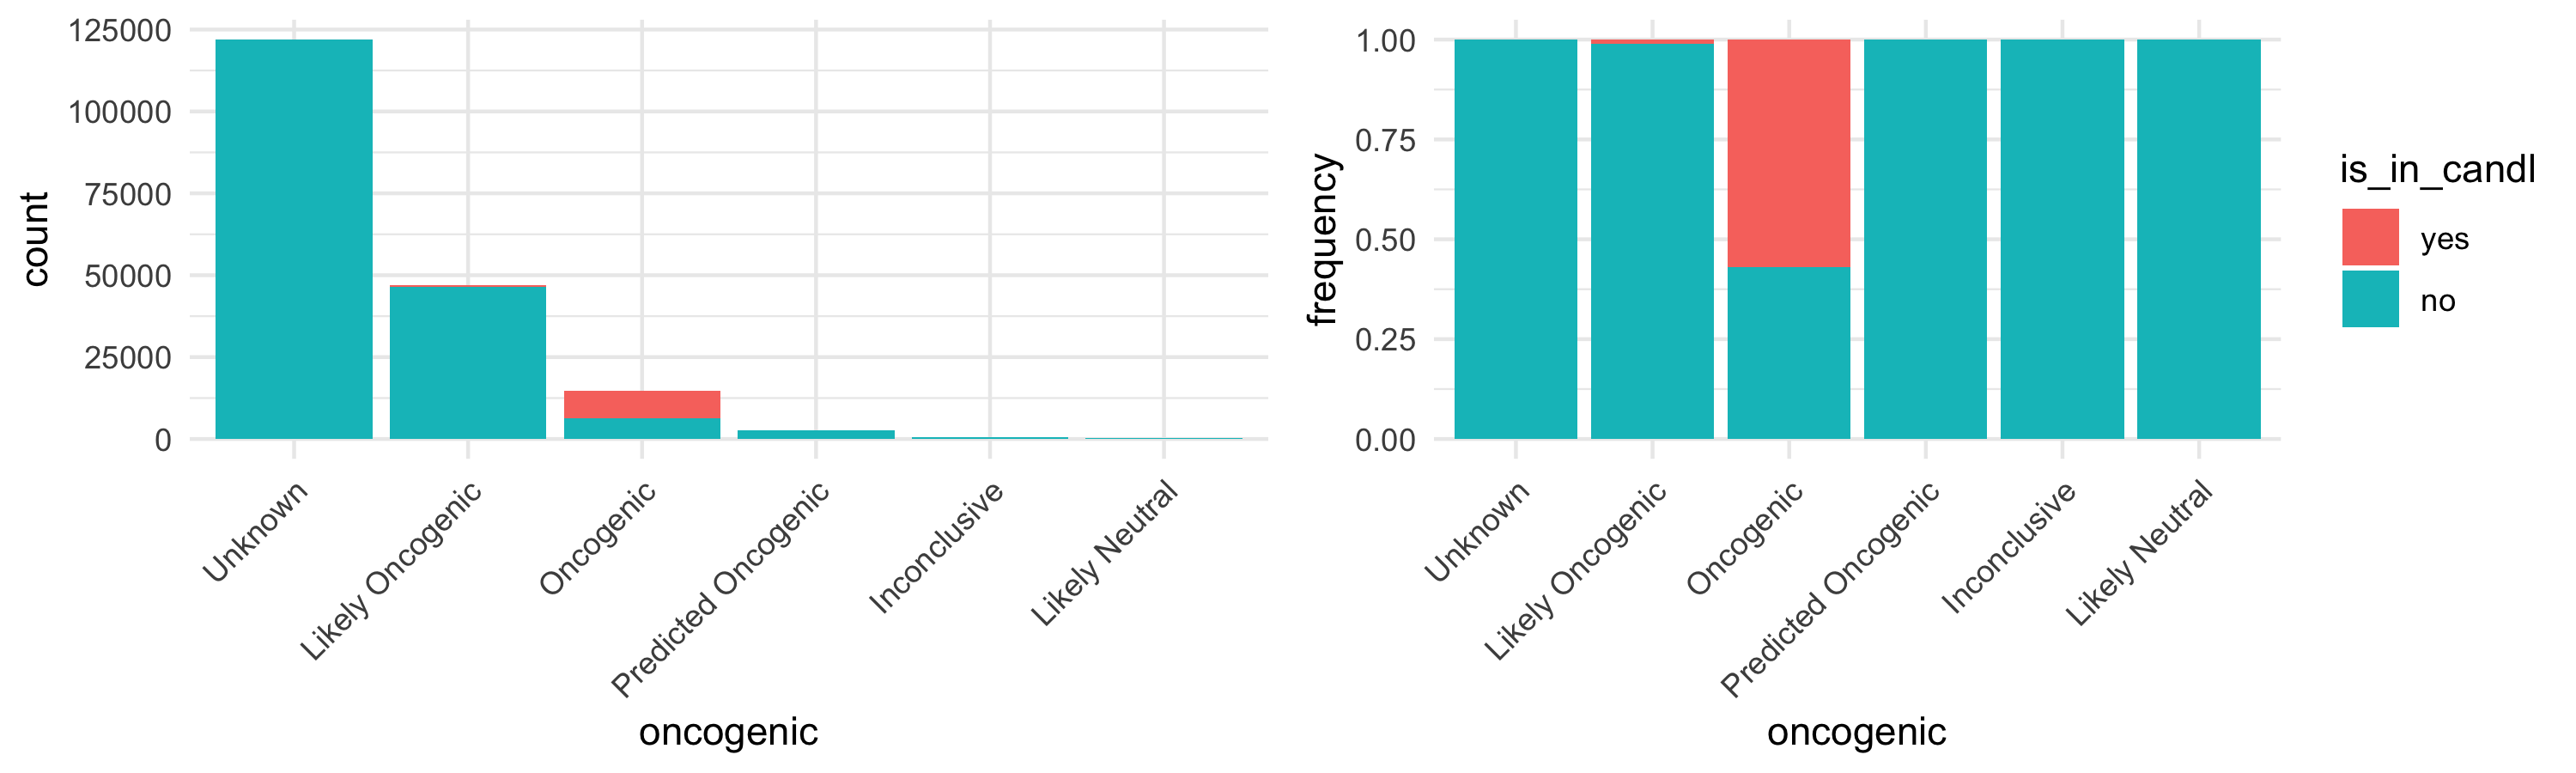

In [14]:
plot_contingency_table_as_histograms(impact, "oncogenic"  , "is_in_candl", 10, 3)

Putative drivers not found in OncoKB:

In [15]:
# number of rows
nrow(impact[impact$is_in_candl == "yes" & impact$is_in_oncokb == "no",])

# number of distinct mutations
length(unique(impact$mut_key[impact$is_in_candl == "yes" & impact$is_in_oncokb == "no"]))

[1] 10

[1] 4

## DoCM

### Get the raw data

Data downloaded from http://www.docm.info/api/v1/variants.tsv?versions=3.2, version 3.2 (13/08/17).

In [16]:
docm <- read.table("../../../data/other_databases/DoCM_variants.tsv",
                   sep = "\t", stringsAsFactors = FALSE, header = TRUE, fill = TRUE, quote = "")

In [17]:
nrow(docm)
length(unique(docm$gene))
colnames(docm)

[1] 1364

[1] 132

[1] "hgvs"              "chromosome"        "start"            
 [4] "stop"              "read"              "variant"          
 [7] "reference_version" "gene"              "mutation_type"    
[10] "amino_acid"        "diseases"          "pubmed_sources"

In [18]:
interesting_columns <- c(
"hgvs",
"chromosome",
"start",
"stop",
"read",
"variant",
"reference_version",
"gene",
"mutation_type",
"amino_acid")

head(docm[, interesting_columns], 10)

hgvs,chromosome,start,stop,read,variant,reference_version,gene,mutation_type,amino_acid
ENST00000361445:c.7514G>C,1,11169361,11169361,C,G,GRCh37,MTOR,missense,p.R2505P
ENST00000361445:c.7500T>G,1,11169375,11169375,A,C,GRCh37,MTOR,missense,p.I2500M
ENST00000361445:c.7498A>T,1,11169377,11169377,T,A,GRCh37,MTOR,missense,p.I2500F
ENST00000361445:c.7255G>A,1,11174420,11174420,C,T,GRCh37,MTOR,missense,p.E2419K
ENST00000361445:c.6667C>A,1,11182179,11182179,G,T,GRCh37,MTOR,missense,p.Q2223K
ENST00000361445:c.6644C>A,1,11184573,11184573,G,T,GRCh37,MTOR,missense,p.S2215Y
ENST00000361445:c.6644C>T,1,11184573,11184573,G,A,GRCh37,MTOR,missense,p.S2215F
ENST00000361445:c.6643T>A,1,11184574,11184574,A,T,GRCh37,MTOR,missense,p.S2215T
ENST00000361445:c.6637C>T,1,11184580,11184580,G,A,GRCh37,MTOR,missense,p.P2213S
ENST00000361445:c.6324C>A,1,11187094,11187094,G,T,GRCh37,MTOR,missense,p.F2108L


### Create keys to join the two dataframes and extract the features

We will join the database using the following keys: 
* `mut_key` for `impact`
* `chromosome`\_`start`\_`read`_`variant` for `docm`

In [19]:
docm$join_key <- paste(docm$chromosome, docm$start, docm$read, docm$variant, sep = "_")
head(docm$join_key)

[1] "1_11169361_C_G" "1_11169375_A_C" "1_11169377_T_A" "1_11174420_C_T"
[5] "1_11182179_G_T" "1_11184573_G_T"

**Verification 1** The `join_key` are not unique:

In [20]:
length(unique(docm$join_key))
nrow(docm)

[1] 1284

[1] 1364

In [21]:
# make them unique
docm <- unique(docm[, c("chromosome", "start", "stop", "read", "variant", "reference_version", "gene",
                        "mutation_type", "join_key")])

length(unique(docm$join_key))
nrow(docm)

[1] 1284

[1] 1284

**Verification 2** not every impact `mut_key` has an analoguous `join_key` in `docm`.

In [22]:
impact$is_in_docm <- "no"
impact$is_in_docm[impact$mut_key %in% docm$join_key] <- "yes"

### Results

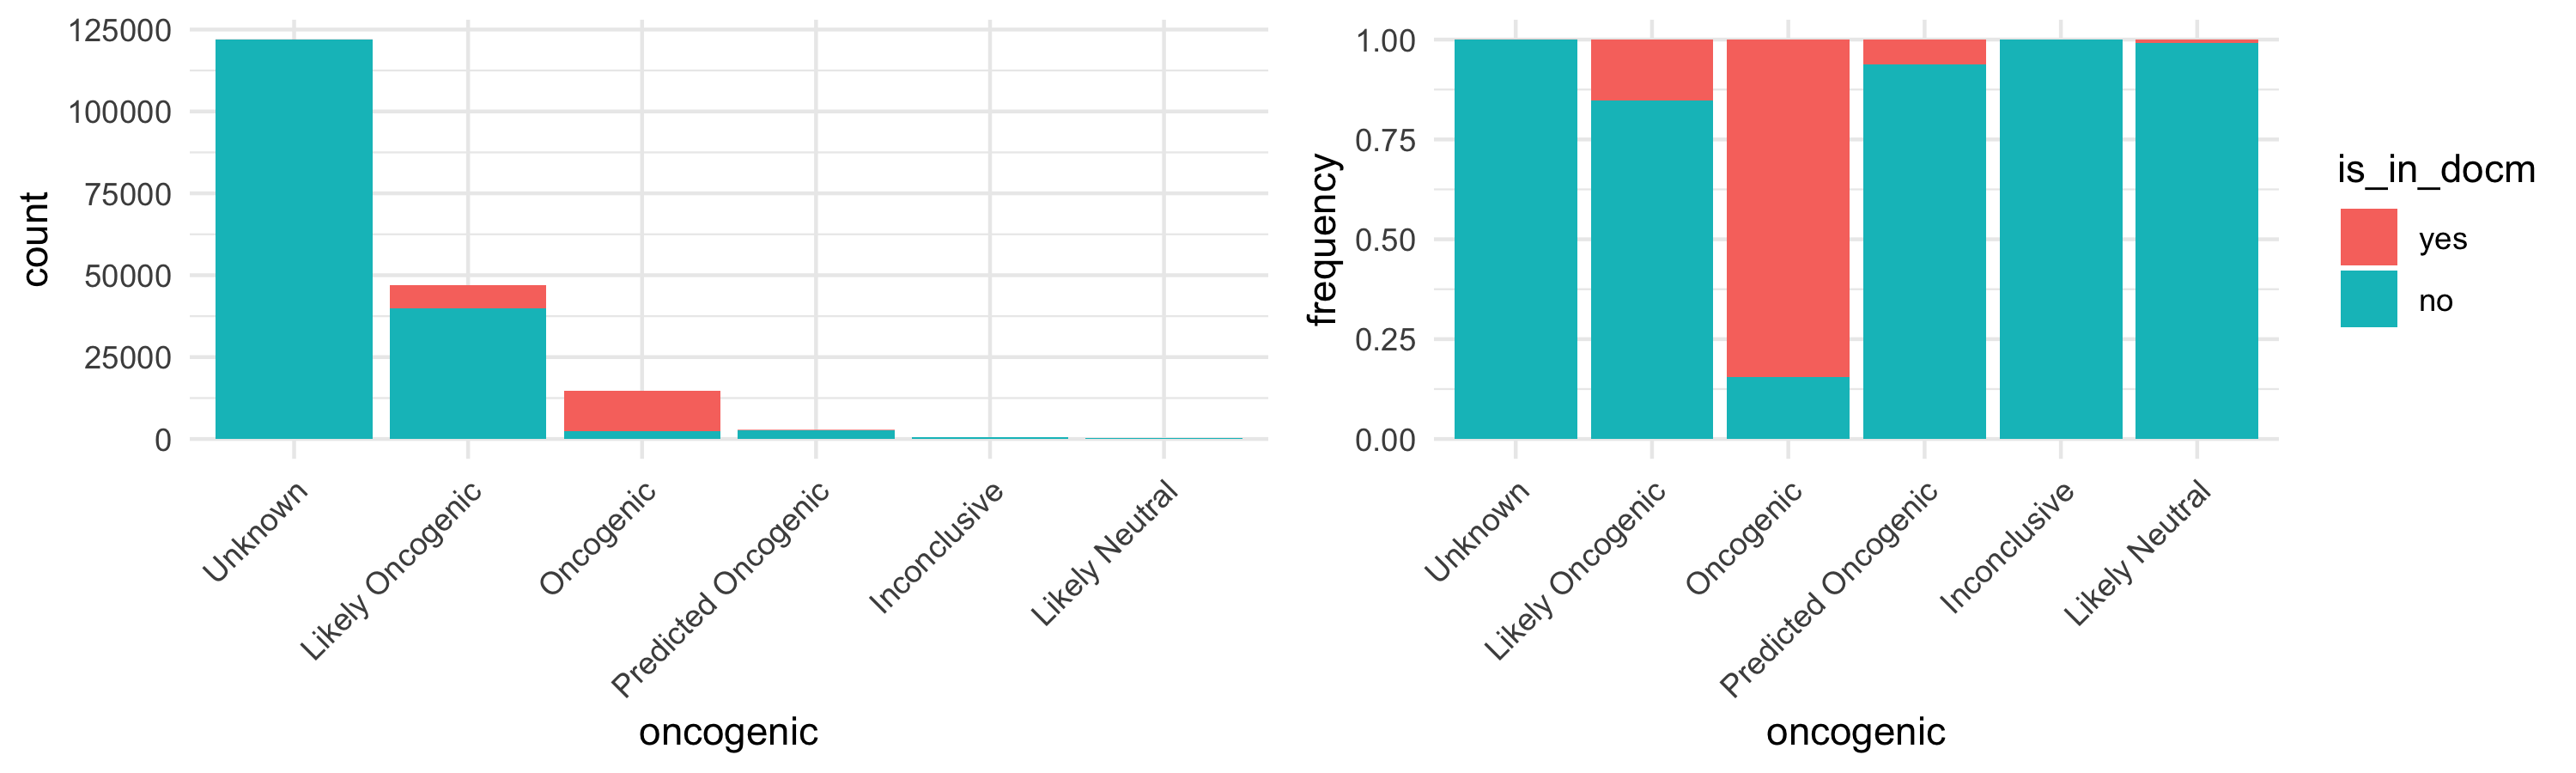

In [23]:
plot_contingency_table_as_histograms(impact, "oncogenic"  , "is_in_docm")

Putative drivers not found in OncoKB:

In [24]:
# number of rows
nrow(impact[impact$is_in_docm == "yes" & impact$is_in_oncokb == "no",])

# number of distinct mutations
length(unique(impact$mut_key[impact$is_in_docm == "yes" & impact$is_in_oncokb == "no"]))

[1] 38

[1] 21

## Precision Medicine Knowledgebase

### Get the raw data

Data downloaded from https://pmkb.weill.cornell.edu under "Welcome to Precision Medicine Knowledgebase", 02/08/18 version.

In [25]:
pmk <- readxl::read_excel("../../../data/other_databases/PMK_IPM_Knowledgebase_Interpretations_Complete_20180807-1922.xlsx")

In [26]:
nrow(pmk)
length(unique(pmk$Gene))
colnames(pmk)

[1] 553

[1] 153

[1] "Gene"            "Tumor Type(s)"   "Tissue Type(s)"  "Variant(s)"     
 [5] "Tier"            "Interpretations" "Citations"       "X__1"           
 [9] "X__2"            "X__3"            "X__4"            "X__5"           
[13] "X__6"            "X__7"            "X__8"            "X__9"           
[17] "X__10"           "X__11"           "X__12"           "X__13"          
[21] "X__14"           "X__15"           "X__16"           "X__17"          
[25] "X__18"           "X__19"           "X__20"

In [27]:
interesting_columns <- c(
"Gene",
"Tumor Type(s)",
"Tissue Type(s)",
"Variant(s)",
"Tier")

head(pmk[, interesting_columns], 10)

Gene,Tumor Type(s),Tissue Type(s),Variant(s),Tier
CSF3R,"Atypical Chronic Myeloid Leukemia, Chronic Neutrophilic Leukemia, Myeloproliferative Neoplasm","Blood, Bone Marrow","CSF3R T618I, CSF3R any nonsense, CSF3R any frameshift",1
MPL,"Essential Thrombocythemia, Myeloproliferative Neoplasm, Primary Myelofibrosis","Blood, Bone Marrow","MPL codon(s) 515 missense, MPL W515L, MPL W515K",1
JAK1,"Acute Myeloid Leukemia, T Lymphoblastic Leukemia/Lymphoma","Blood, Bone Marrow",NA,1
NRAS,"Acute Myeloid Leukemia, B Lymphoblastic Leukemia/Lymphoma, Chronic Myelomonocytic Leukemia, Myelodysplastic Syndrome","Blood, Bone Marrow",NA,1
NOTCH2,"Diffuse Large B Cell Lymphoma, Marginal Zone B Cell Lymphoma","Blood, Bone Marrow","NOTCH2 I2304fs, NOTCH2 exon(s) 34 frameshift",1
RIT1,"Acute Myeloid Leukemia, Chronic Myelomonocytic Leukemia, Myelodysplastic Syndrome","Blood, Bone Marrow",RIT1 M90I,1
DNMT3A,"Acute Myeloid Leukemia, Chronic Myelomonocytic Leukemia, Myelodysplastic Syndrome, Myeloproliferative Neoplasm, T Lymphoblastic Leukemia/Lymphoma","Blood, Bone Marrow",NA,1
FANCL,Myelodysplastic Syndrome,"Blood, Bone Marrow",NA,1
XPO1,Chronic Lymphocytic Leukemia,"Blood, Bone Marrow",NA,1
CXCR4,Lymphoplasmacytic Lymphoma,"Blood, Bone Marrow",NA,1


We stopped here as there is no easy way to link this database with `impact`.

## CIViC

Data downloaded from https://civicdb.org/releases under "Variant Summaries", 01/07/18 version.

In [28]:
civic <- read.table("../../../data/other_databases/CIViC_01-Jul-2018-VariantSummaries.tsv",
                    sep = "\t", stringsAsFactors = FALSE, header = TRUE, fill = TRUE, quote = "")

In [29]:
nrow(civic)
length(unique(civic$gene))
colnames(civic)

[1] 1885

[1] 353

[1] "variant_id"                 "variant_civic_url"         
 [3] "gene"                       "entrez_id"                 
 [5] "variant"                    "summary"                   
 [7] "variant_groups"             "chromosome"                
 [9] "start"                      "stop"                      
[11] "reference_bases"            "variant_bases"             
[13] "representative_transcript"  "ensembl_version"           
[15] "reference_build"            "chromosome2"               
[17] "start2"                     "stop2"                     
[19] "representative_transcript2" "variant_types"             
[21] "hgvs_expressions"           "last_review_date"          
[23] "civic_actionability_score"

In [30]:
interesting_columns <- c(
"gene",
"variant",
"chromosome",
"start",
"stop",
"reference_bases",
"variant_bases",
"representative_transcript",
"ensembl_version",
"reference_build",
"variant_types",
"hgvs_expressions",
"civic_actionability_score")

head(civic[, interesting_columns], 100)

gene,variant,chromosome,start,stop,reference_bases,variant_bases,representative_transcript,ensembl_version,reference_build,variant_types,hgvs_expressions,civic_actionability_score
ABL1,BCR-ABL,22,23522397,23632600,,,ENST00000305877.8,75,GRCh37,transcript_fusion,,238.0
ABL1,BCR-ABL T334I,9,133748283,133748283,C,T,ENST00000372348.2,75,GRCh37,"transcript_fusion,missense_variant","NM_007313.2:c.1001C>T,NP_005148.2:p.Thr315Ile,ENST00000372348.2:c.1001C>T,NC_000009.11:g.133748283C>T",54.0
ABL1,BCR-ABL E255K,9,133738363,133738363,G,A,ENST00000318560.5,75,GRCh37,"transcript_fusion,missense_variant","NC_000009.11:g.133738363G>A,NM_005157.5:c.763G>A,NP_005148.2:p.Glu255Lys,ENST00000318560.5:c.763G>A",17.0
AKT1,E17K,14,105246551,105246551,C,T,ENST00000407796.2,75,GRCh37,missense_variant,"NC_000014.8:g.105246551C>T,NM_001014432.1:c.49G>A,NP_001014432.1:p.Glu17Lys,ENST00000407796.2:c.49G>A",32.5
ALK,EML4-ALK,2,42396490,42522656,,,ENST00000318522.5,75,GRCh37,transcript_fusion,,48.0
ALK,EML4-ALK C1156Y,2,29445258,29445258,C,T,ENST00000389048.3,75,GRCh37,"transcript_fusion,missense_variant","ENST00000389048.3:c.3467G>A,NC_000002.11:g.29445258C>T,NM_004304.4:c.3467G>A,NP_004295.2:p.Cys1156Tyr",19.0
ALK,EML4-ALK L1196M,2,29443631,29443631,G,T,ENST00000389048.3,75,GRCh37,"transcript_fusion,missense_variant","ENST00000389048.3:c.3586C>A,NC_000002.11:g.29443631G>T,NM_004304.4:c.3586C>A,NP_004295.2:p.Leu1196Met",31.0
ALK,F1174L,2,29443695,29443695,G,T,ENST00000389048.3,75,GRCh37,missense_variant,"NM_004304.4:c.3522C>A,NP_004295.2:p.Phe1174Leu,NC_000002.11:g.29443695G>T,ENST00000389048.3:c.3522C>A",33.5
ALK,R1275Q,2,29432664,29432664,C,T,ENST00000389048.3,75,GRCh37,missense_variant,"NM_004304.4:c.3824G>A,NP_004295.2:p.Arg1275Gln,NC_000002.11:g.29432664C>T,ENST00000389048.3:c.3824G>A",23.0
ARAF,S214C,X,47426121,47426121,C,G,ENST00000377045.4,75,GRCh37,missense_variant,"NC_000023.10:g.47426121C>G,NM_001654.4:c.641C>G,NP_001645.1:p.Ser214Cys,ENST00000377045.4:c.641C>G",11.0


### Create keys to join the two dataframes and extract the features

We will join the database using the following keys: 
* `mut_key` for `impact`
* `chromosome`\_`start`_`reference_bases`_`variant_bases` for `civic`

In [31]:
civic$join_key <- paste(civic$chromosome, civic$start, civic$reference_bases, civic$variant_bases, sep = "_")

# sometimes we can't find a key
civic$join_key[civic$chromosome == "" |
               civic$start == "" |
               (civic$reference_bases == "" & civic$variant_bases   == "")] <- "no_key"

head(civic$join_key)

[1] "no_key"           "9_133748283_C_T"  "9_133738363_G_A"  "14_105246551_C_T"
[5] "no_key"           "2_29445258_C_T"

A lot of variant are `EXON 21 DELETION`, `DELETION`, `AMPLIFICATION` instead of a precise mutation, that's why we can't compute a key for these variants, we won't work with them and thus a lot of mutations are not considered in the study that follows.

In [32]:
print_count_and_proportion(nrow(civic[civic$join_key == "no_key",]), nrow(civic))

# delete the rows where we couldn't find a key
civic <- civic[civic$join_key != "no_key",]

[1] "1082 over 1885 (57.40%)"

**Verification 1** The `join_key` are not unique:

In [33]:
length(unique(civic$join_key))
nrow(civic)

[1] 797

[1] 803

In [34]:
# make them unique
civic <- unique(civic[, c("gene", "chromosome", "start", "stop", "reference_bases", "variant_bases", "join_key")])

length(unique(civic$join_key))
nrow(civic)

[1] 797

[1] 797

**Verification 2** not every impact `mut_key` has an analoguous `join_key` in `civic`.

In [35]:
impact$is_in_civic <- "no"
impact$is_in_civic[impact$mut_key %in% civic$join_key] <- "yes"

### Results

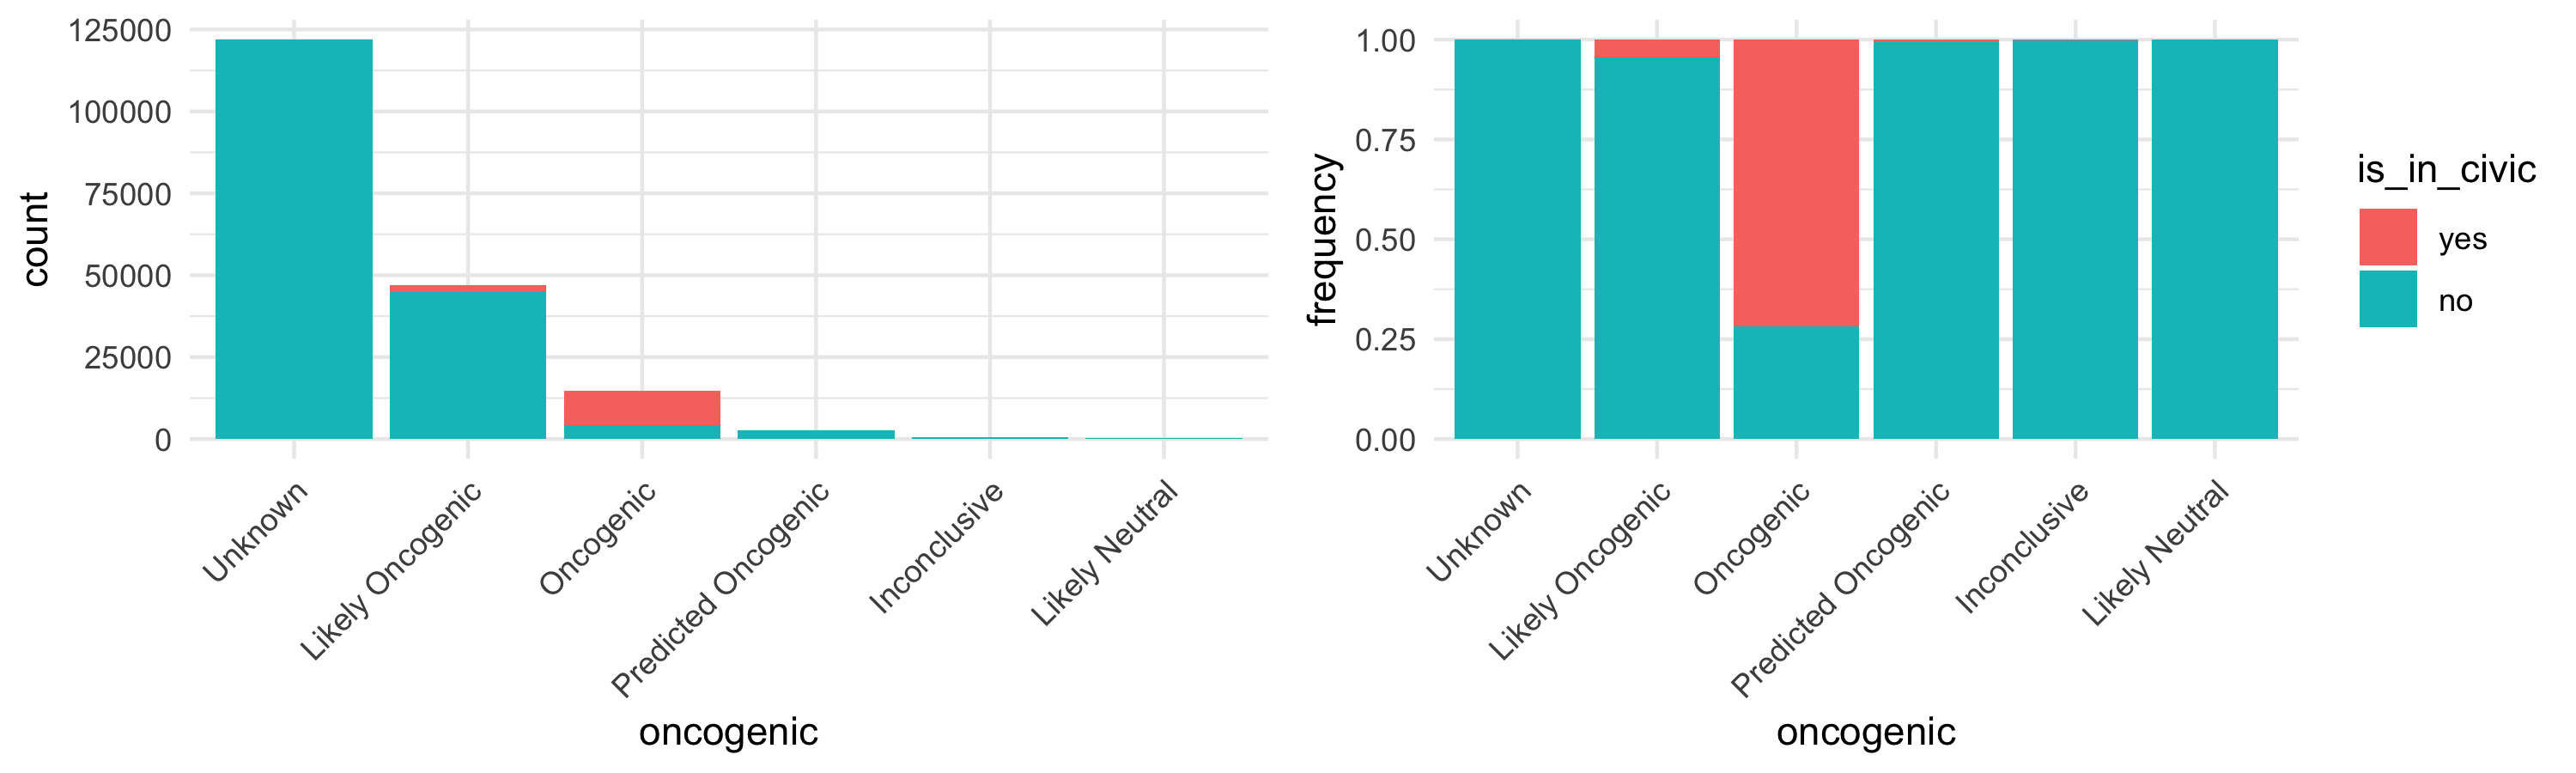

In [36]:
plot_contingency_table_as_histograms(impact, "oncogenic"  , "is_in_civic")

Putative drivers not found in OncoKB:

In [37]:
# number of rows
nrow(impact[impact$is_in_civic == "yes" & impact$is_in_oncokb == "no",])

# number of distinct mutations
length(unique(impact$mut_key[impact$is_in_civic == "yes" & impact$is_in_oncokb == "no"]))

[1] 46

[1] 26

## Cancer Genome Interpreter

### Get the raw data

Data downloaded from https://www.cancergenomeinterpreter.org/mutations, 01/17/18 version.

In [38]:
cgi <- read.table("../../../data/other_databases/CGI_catalog_of_validated_oncogenic_mutations.tsv",
                  sep = "\t", stringsAsFactors = FALSE, header = TRUE, fill = TRUE)

In [39]:
nrow(cgi)
length(unique(cgi$gene))
colnames(cgi)

[1] 5601

[1] 247

[1] "gene"           "gdna"           "protein"        "transcript"    
[5] "info"           "context"        "cancer_acronym" "source"        
[9] "reference"

In [40]:
head(cgi, 10)

gene,gdna,protein,transcript,info,context,cancer_acronym,source,reference
ABCB4,chr7:g.87053221C>T,.,ENST00000265723,CSQN=SpliceDonorSNV;C2=SpliceDonorOfExon17_At_chr7:87053221;aliases=ENSP00000265723;source=Ensembl,germline,HC-PR,ClinVar,Clinvar:NM_018849.2(ABCB4):c.2211+1G>A AND Progressive familial intrahepatic cholestasis 3
ABL1,chr9:g.133738306G>A,p.E236K,ENST00000318560,CSQN=Missense;codon_pos=133738306-133738307-133738308;ref_codon_seq=GAG;aliases=ENSP00000323315;source=Ensembl,somatic,CML,DoCM,PMID:21562040
ABL1,chr9:g.133738309A>G,p.M237V,ENST00000318560,"CSQN=Missense;reference_codon=ATG;candidate_codons=GTA,GTC,GTG,GTT;candidate_mnv_variants=chr9:g.133738309_133738311delATGinsGTA,chr9:g.133738309_133738311delATGinsGTC,chr9:g.133738309_133738311delATGinsGTT;aliases=ENSP00000323315;source=Ensembl",somatic,CML,Biomarker,PMID:21562040
ABL1,chr9:g.133738325T>C,p.I242T,ENST00000318560,"CSQN=Missense;reference_codon=ATC;candidate_codons=ACA,ACG,ACT,ACC;candidate_mnv_variants=chr9:g.133738325_133738326delTCinsCA,chr9:g.133738325_133738326delTCinsCG,chr9:g.133738325_133738326delTCinsCT;aliases=ENSP00000323315;source=Ensembl",somatic,CML,Biomarker,PMID:21562040
ABL1,chr9:g.133738330A>G,p.M244V,ENST00000318560,"CSQN=Missense;codon_pos=133738330-133738331-133738332;ref_codon_seq=ATG;aliases=ENSP00000323315;source=Ensembl__CSQN=Missense;reference_codon=ATG;candidate_codons=GTA,GTC,GTG,GTT;candidate_mnv_variants=chr9:g.133738330_133738332delATGinsGTA,chr9:g.133738330_133738332delATGinsGTC,chr9:g.133738330_133738332delATGinsGTT;aliases=ENSP00000323315;source=Ensembl",somatic,CML,DoCM__Biomarker__OncoKB,PMID:21562040__PMID:20367437__PMID:21895409__PMID:25157968__PMID:12399961__PMID:12576318__PMID:23676790__PMID:18223278__PMID:12623848__PMID:21888027
ABL1,chr9:g.133738340A>G,p.K247R,ENST00000318560,"CSQN=Missense;reference_codon=AAG;candidate_codons=AGG,AGA,CGA,CGC,CGG,CGT;candidate_mnv_variants=chr9:g.133738340_133738341delAGinsGA,chr9:g.133738339_133738340delAAinsCG,chr9:g.133738339_133738341delAAGinsCGA,chr9:g.133738339_133738341delAAGinsCGC,chr9:g.133738339_133738341delAAGinsCGT;aliases=ENSP00000323315;source=Ensembl",somatic,CML,Biomarker,PMID:21562040
ABL1,chr9:g.133738342C>G,p.L248V,ENST00000318560,"CSQN=Missense;codon_pos=133738342-133738343-133738344;ref_codon_seq=CTG;aliases=ENSP00000323315;source=Ensembl__CSQN=Missense;reference_codon=CTG;candidate_codons=GTA,GTC,GTG,GTT;candidate_mnv_variants=chr9:g.133738342_133738344delCTGinsGTA,chr9:g.133738342_133738344delCTGinsGTC,chr9:g.133738342_133738344delCTGinsGTT;aliases=ENSP00000323315;source=Ensembl",somatic,CML,DoCM__Biomarker__OncoKB,PMID:21562040__PMID:18354488__PMID:20367437__PMID:25157968__PMID:21221851__PMID:17008892__PMID:12623848
ABL1,chr9:g.133738348G>A,p.G250R,ENST00000318560,"CSQN=Missense;reference_codon=GGG;candidate_codons=AGG,AGA,CGA,CGC,CGG,CGT;candidate_snv_variants=chr9:g.133738348G>C;candidate_mnv_variants=chr9:g.133738348_133738350delGGGinsAGA,chr9:g.133738348_133738350delGGGinsCGA,chr9:g.133738348_133738350delGGGinsCGC,chr9:g.133738348_133738350delGGGinsCGT;aliases=ENSP00000323315;source=Ensembl",somatic,CML,Biomarker,PMID:21562040
ABL1,chr9:g.133738349G>A,p.G250E,ENST00000318560,"CSQN=Missense;reference_codon=GGG;candidate_codons=GAG,GAA;candidate_mnv_variants=chr9:g.133738349_133738350delGGinsAA;aliases=ENSP00000323315;source=Ensembl__CSQN=Missense;codon_pos=133738348-133738349-133738350;ref_codon_seq=GGG;aliases=ENSP00000323315;source=Ensembl",somatic,CML,DoCM__Biomarker__OncoKB,PMID:21562040__PMID:21505103__PMID:20367437__PMID:21895409__PMID:22870928__PMID:25157968__PMID:11964322__PMID:23676790__PMID:12623848
ABL1,chr9:g.133738355A>G,p.Q252R,ENST00000318560,"CSQN=Missense;reference_codon=CAG;candidate_codons=AGG,AGA,CGA,CGC,CGG,CGT;candidate_mnv_variants=chr9:g.133738354_133738355delCAinsAG,chr9:g.133738355_133738356delAGinsGA,chr9:g.133738355_133738356delAGinsGC,chr9:g.133738355_133738356delAGinsGT,chr9:g.133738354_133738356delCAGinsAGA;aliases=ENSP

### Create keys to join the two dataframes and extract the features

We will join the database using the following keys: 
* `Hugo_Symbol`.`HGVSp_Short` for `impact`
* `gene`.`protein` for `cgi`

In [41]:
impact$cgi_key <- paste0(impact$Hugo_Symbol, '.', impact$HGVSp_Short)
head(impact$cgi_key)

[1] "TP53.p.T256P"   "PIK3R3.p.I298M" "ATR.p.R2431M"   "PDGFRA.p.L465M"
[5] "FBXW7."         "FBXW7.p.G61*"

In [42]:
cgi$join_key <- paste0(cgi$gene, '.', cgi$protein)
head(cgi$join_key)

[1] "ABCB4.."      "ABL1.p.E236K" "ABL1.p.M237V" "ABL1.p.I242T" "ABL1.p.M244V"
[6] "ABL1.p.K247R"

We are going to link the databases on the exact `join_key`, and we will lost some mutations, for example `FBXW7.p.G61*` and `FBXW7.p.E62*` are likely to have the same effect but maybe only the first one is in cgi. The study that follows is thus not complete.

**Verification 1** The `join_key` are not unique:

In [43]:
length(unique(cgi$join_key))
nrow(cgi)

[1] 5232

[1] 5601

In [44]:
# make them unique
cgi <- unique(cgi[, c("gene", "protein", "join_key")])

length(unique(cgi$join_key))
nrow(cgi)

[1] 5232

[1] 5232

**Verification 2** not every impact `cgi_key` has an analoguous `join_key` in `cgi`.

In [45]:
impact$is_in_cgi <- "no"
impact$is_in_cgi[impact$cgi_key %in% cgi$join_key] <- "yes"

### Results

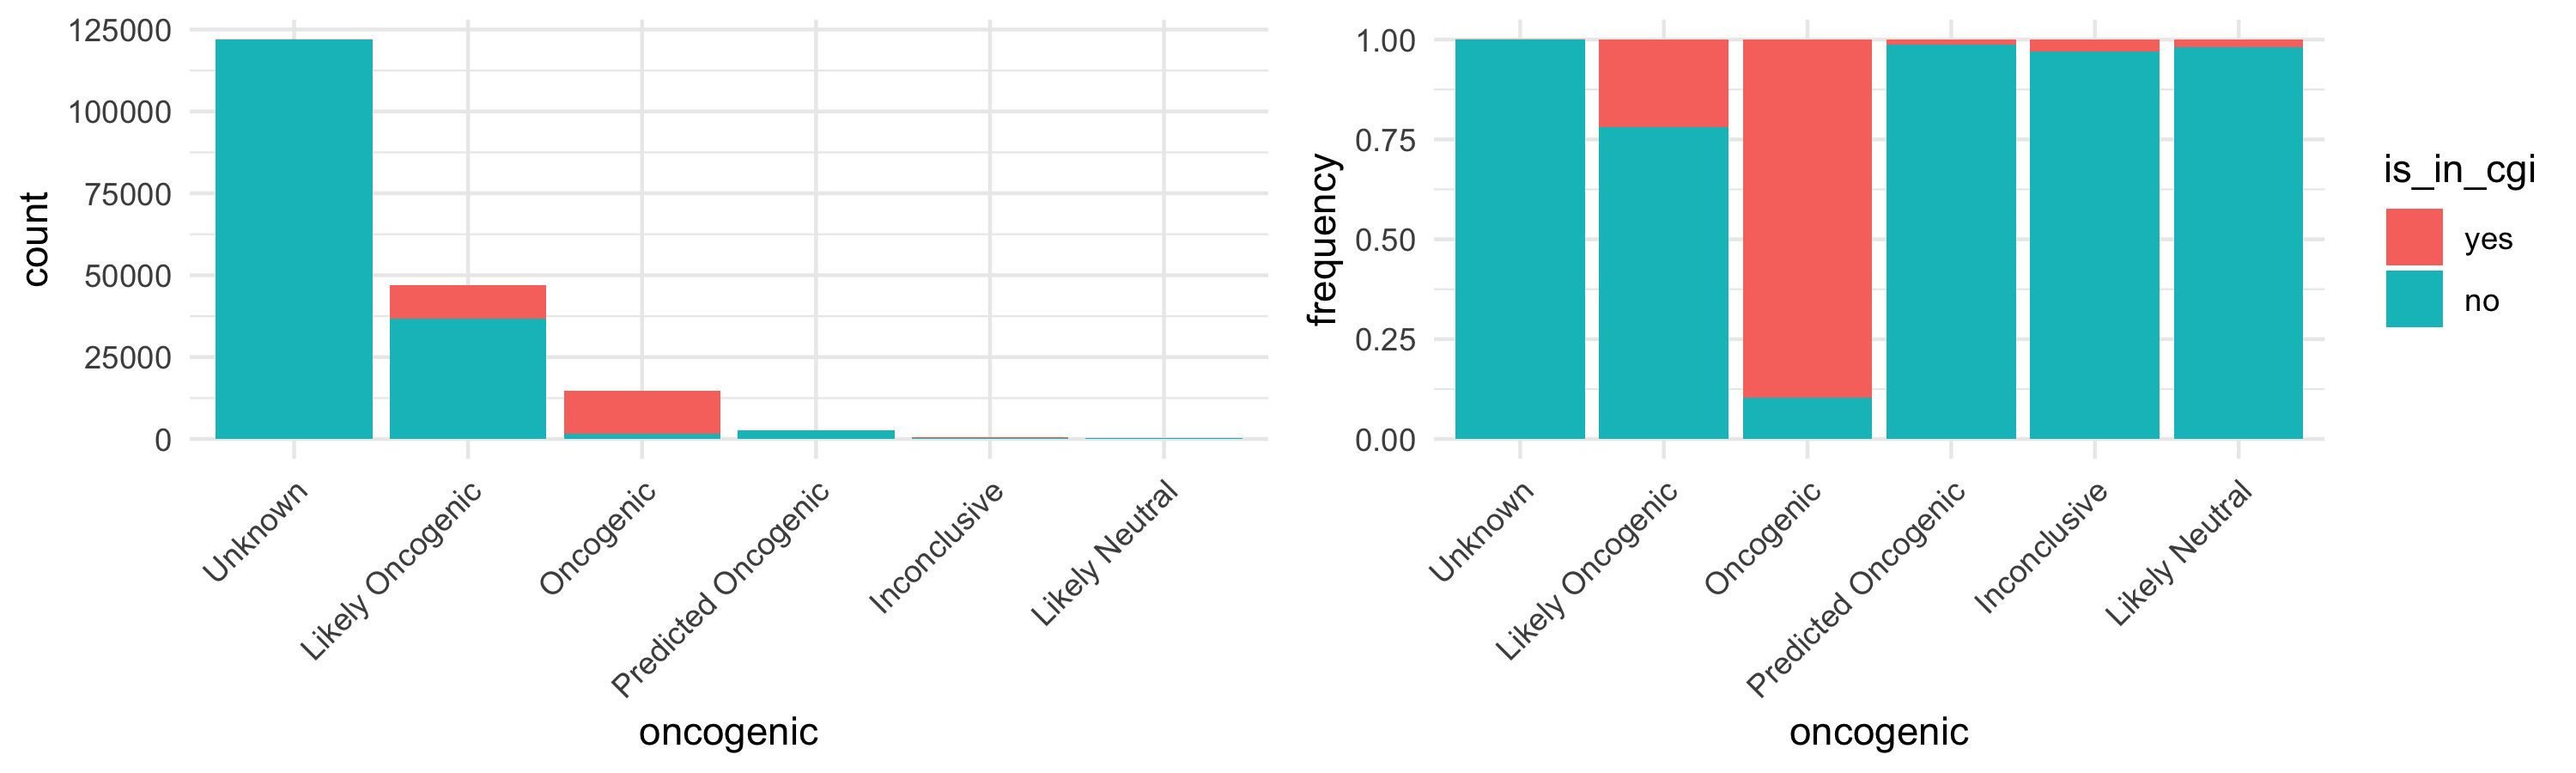

In [46]:
plot_contingency_table_as_histograms(impact, "oncogenic"  , "is_in_cgi")

Putative drivers not found in OncoKB:

In [47]:
# number of rows
nrow(impact[impact$is_in_cgi == "yes" & impact$is_in_oncokb == "no",])

# number of distinct mutations
length(unique(impact$mut_key[impact$is_in_cgi == "yes" & impact$is_in_oncokb == "no"]))

[1] 107

[1] 58

### Other linking method

Let's try to link the other databases by being less specific on the `join_key`:
* `Hugo_Symbol`.`HGVSp_Short` for `impact` and `Hugo_Symbol`.`trunc` when the mutation is truncating
* `gene`.`protein` for `cgi` and `gene`.`trunc` when the mutation is truncating

In [48]:
cgi <- read.table("../../../data/other_databases/CGI_catalog_of_validated_oncogenic_mutations.tsv",
                  sep = "\t", stringsAsFactors = FALSE, header = TRUE, fill = TRUE)

In [49]:
impact$cgi_key <- paste0(impact$Hugo_Symbol, '.', impact$HGVSp_Short)

is_trunc <- which(impact$Consequence %in% c("splicing", "stopgain_SNV", "frameshift_insertion"))
impact$cgi_key[is_trunc] <- paste0(impact$Hugo_Symbol[is_trunc], ".trunc")
head(impact$cgi_key)

[1] "TP53.p.T256P"   "PIK3R3.p.I298M" "ATR.p.R2431M"   "PDGFRA.p.L465M"
[5] "FBXW7.trunc"    "FBXW7.trunc"

In [50]:
get_cgi_consequence <- function(info_string) {
    info_string <- strsplit(info_string, ";")[[1]][1]
    info_string <- strsplit(info_string, '=')[[1]][2]
    
    return (info_string)
}

get_cgi_consequence("CSQN=Missense;reference_codon=GGG;candidate_codons=GAG,GAA;candidate_mnv_variants=chr9:g.133738349_133738350delGGinsAA;aliases=ENSP00000323315;source=Ensembl__CSQN=Missense;codon_pos=133738348-133738349-133738350;ref_codon_seq=GGG;aliases=ENSP00000323315;source=Ensembl")

[1] "Missense"

In [51]:
cgi$Consequence <- sapply(cgi$info, get_cgi_consequence)
get_table(cgi$Consequence)

values,count,freq
Missense,2905,51.9%
Frameshift,1464,26.1%
Nonsense,905,16.2%
SpliceDonorSNV,100,1.8%
SpliceAcceptorSNV,100,1.8%
InFrameDeletion,29,0.5%
SpliceAcceptorDeletion,16,0.3%
Synonymous,13,0.2%
CdsStartSNV,13,0.2%
MultiAAMissense,12,0.2%


In [52]:
truncating_mutations <- c("Frameshift", "Nonsense", "SpliceDonorSNV", "SpliceAcceptorSNV", "SpliceAcceptorDeletion")

In [53]:
cgi$protein[cgi$Consequence %in% c("Frameshift", "Nonsense", "SpliceDonorSNV", "SpliceAcceptorSNV", "SpliceAcceptorDeletion")] <- "trunc"

In [54]:
cgi$join_key <- paste0(cgi$gene, '.', cgi$protein)

is_trunc <- which(cgi$Consequence %in% c("Frameshift", "Nonsense", "SpliceDonorSNV", "SpliceAcceptorSNV", "SpliceAcceptorDeletion"))
cgi$join_key[is_trunc] <- paste0(cgi$gene[is_trunc], ".trunc")
head(impact$cgi_key)

[1] "TP53.p.T256P"   "PIK3R3.p.I298M" "ATR.p.R2431M"   "PDGFRA.p.L465M"
[5] "FBXW7.trunc"    "FBXW7.trunc"

Make the `join_key` unique:

In [55]:
cgi <- unique(cgi[, c("gene", "join_key")])

length(unique(cgi$join_key))
nrow(cgi)

[1] 2948

[1] 2948

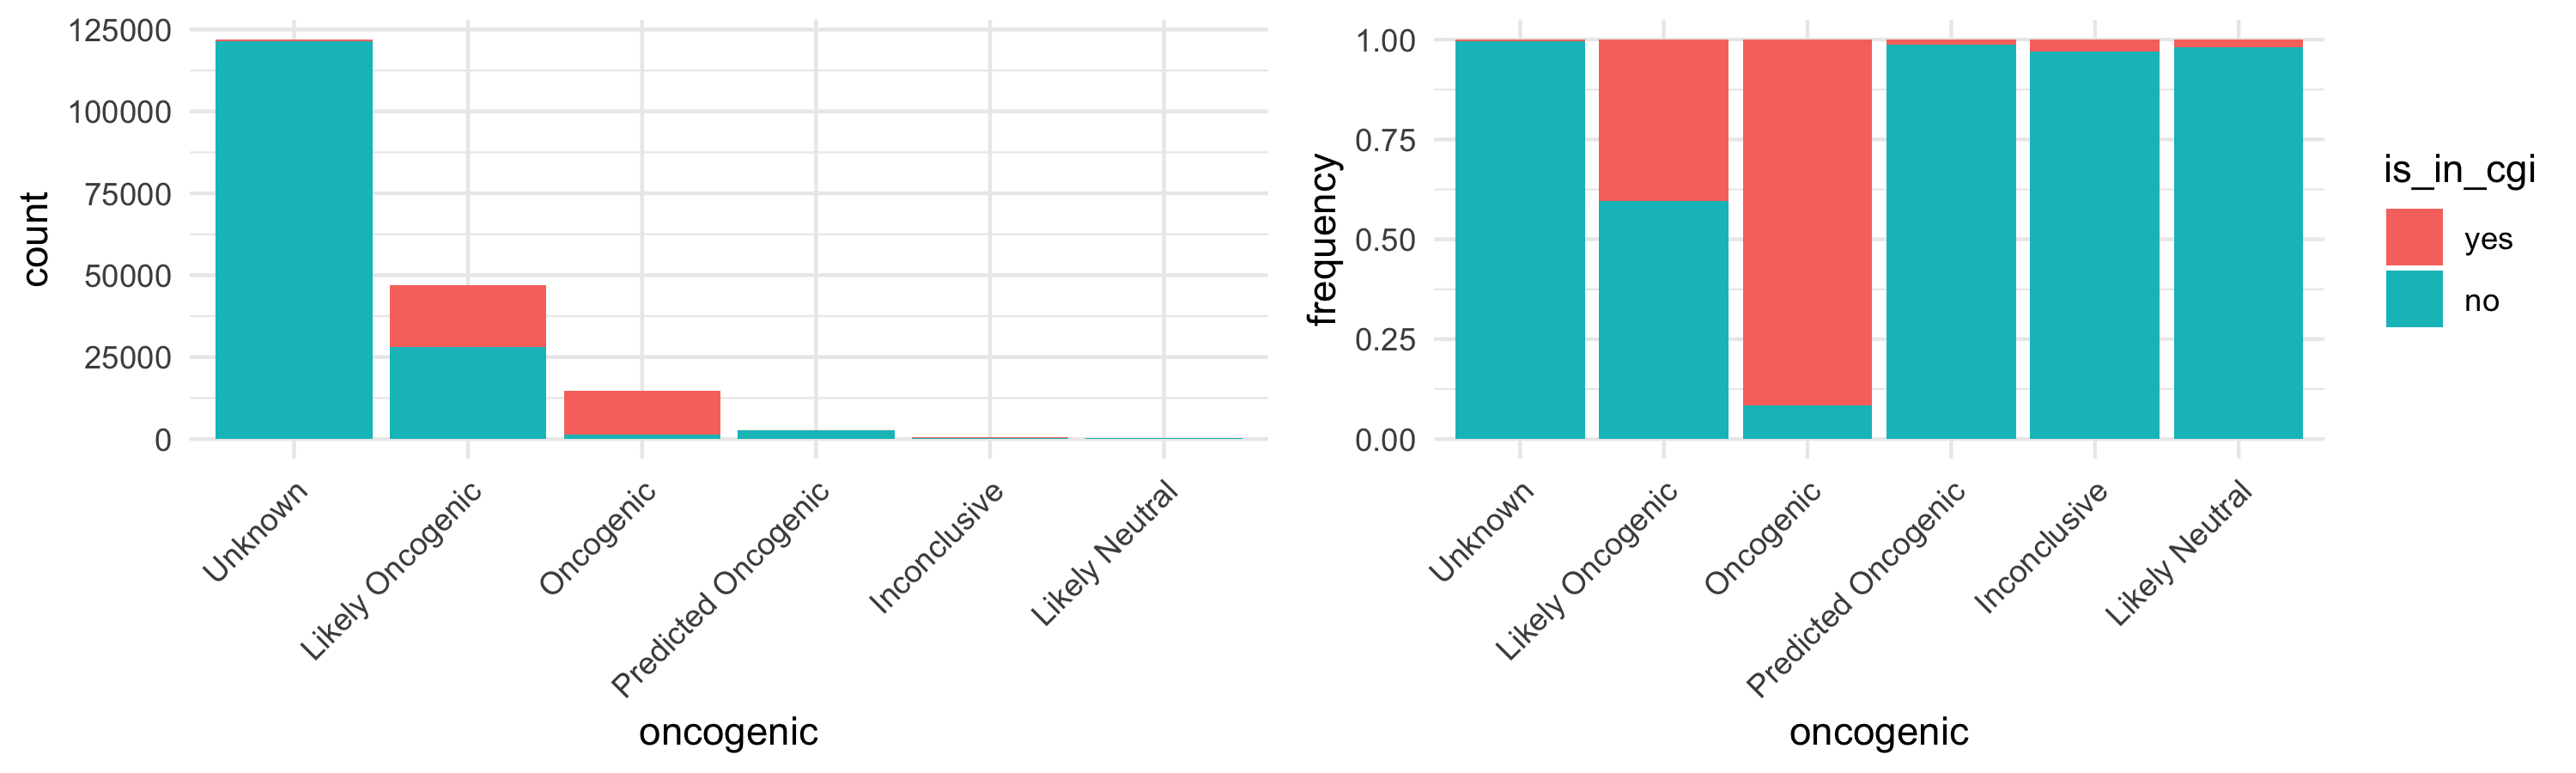

In [56]:
impact$is_in_cgi <- "no"
impact$is_in_cgi[impact$cgi_key %in% cgi$join_key] <- "yes"

plot_contingency_table_as_histograms(impact, "oncogenic"  , "is_in_cgi")

In [57]:
# number of rows
nrow(impact[impact$is_in_cgi == "yes" & impact$is_in_oncokb == "no",])

# number of distinct mutations
length(unique(impact$mut_key[impact$is_in_cgi == "yes" & impact$is_in_oncokb == "no"]))

[1] 552

[1] 446

## Study the IMPACT variants repartition accross the databases

In [58]:
oncokb_mutations <- impact[impact$is_in_oncokb == "yes",]
candl_mutations  <- impact[impact$is_in_candl  == "yes",]
docm_mutations   <- impact[impact$is_in_docm   == "yes",]
civic_mutations  <- impact[impact$is_in_civic  == "yes",]
cgi_mutations    <- impact[impact$is_in_cgi    == "yes",]

oncokb_mutations$database <- "oncokb"
candl_mutations$database  <- "candl"
docm_mutations$database   <- "docm"
civic_mutations$database  <- "civic"
cgi_mutations$database    <- "cgi"

annotated_mutations <- rbind(oncokb_mutations, candl_mutations, docm_mutations, civic_mutations, cgi_mutations)

In [62]:
impact$category <- "not found"
impact$category[impact$is_in_oncokb == "yes"] <- "oncokb"
impact$category[impact$is_in_oncokb == "no" &
                (impact$is_in_candl  == "yes" |
                 impact$is_in_docm   == "yes" |
                 impact$is_in_civic  == "yes" |
                 impact$is_in_cgi    == "yes")] <- "candl, docm, civic or cgi"
get_table(impact$category)

values,count,freq
not found,122085,65.3%
oncokb,64377,34.4%
"candl, docm, civic or cgi",606,0.3%
-- total --,187068,100%


### At the row level

In [68]:
annotated_mutations <- as.data.frame(annotated_mutations %>% group_by(mut_key) %>%
                                                             mutate(count = length(unique(database)),
                                                                    repartition = toString(unique(database))))

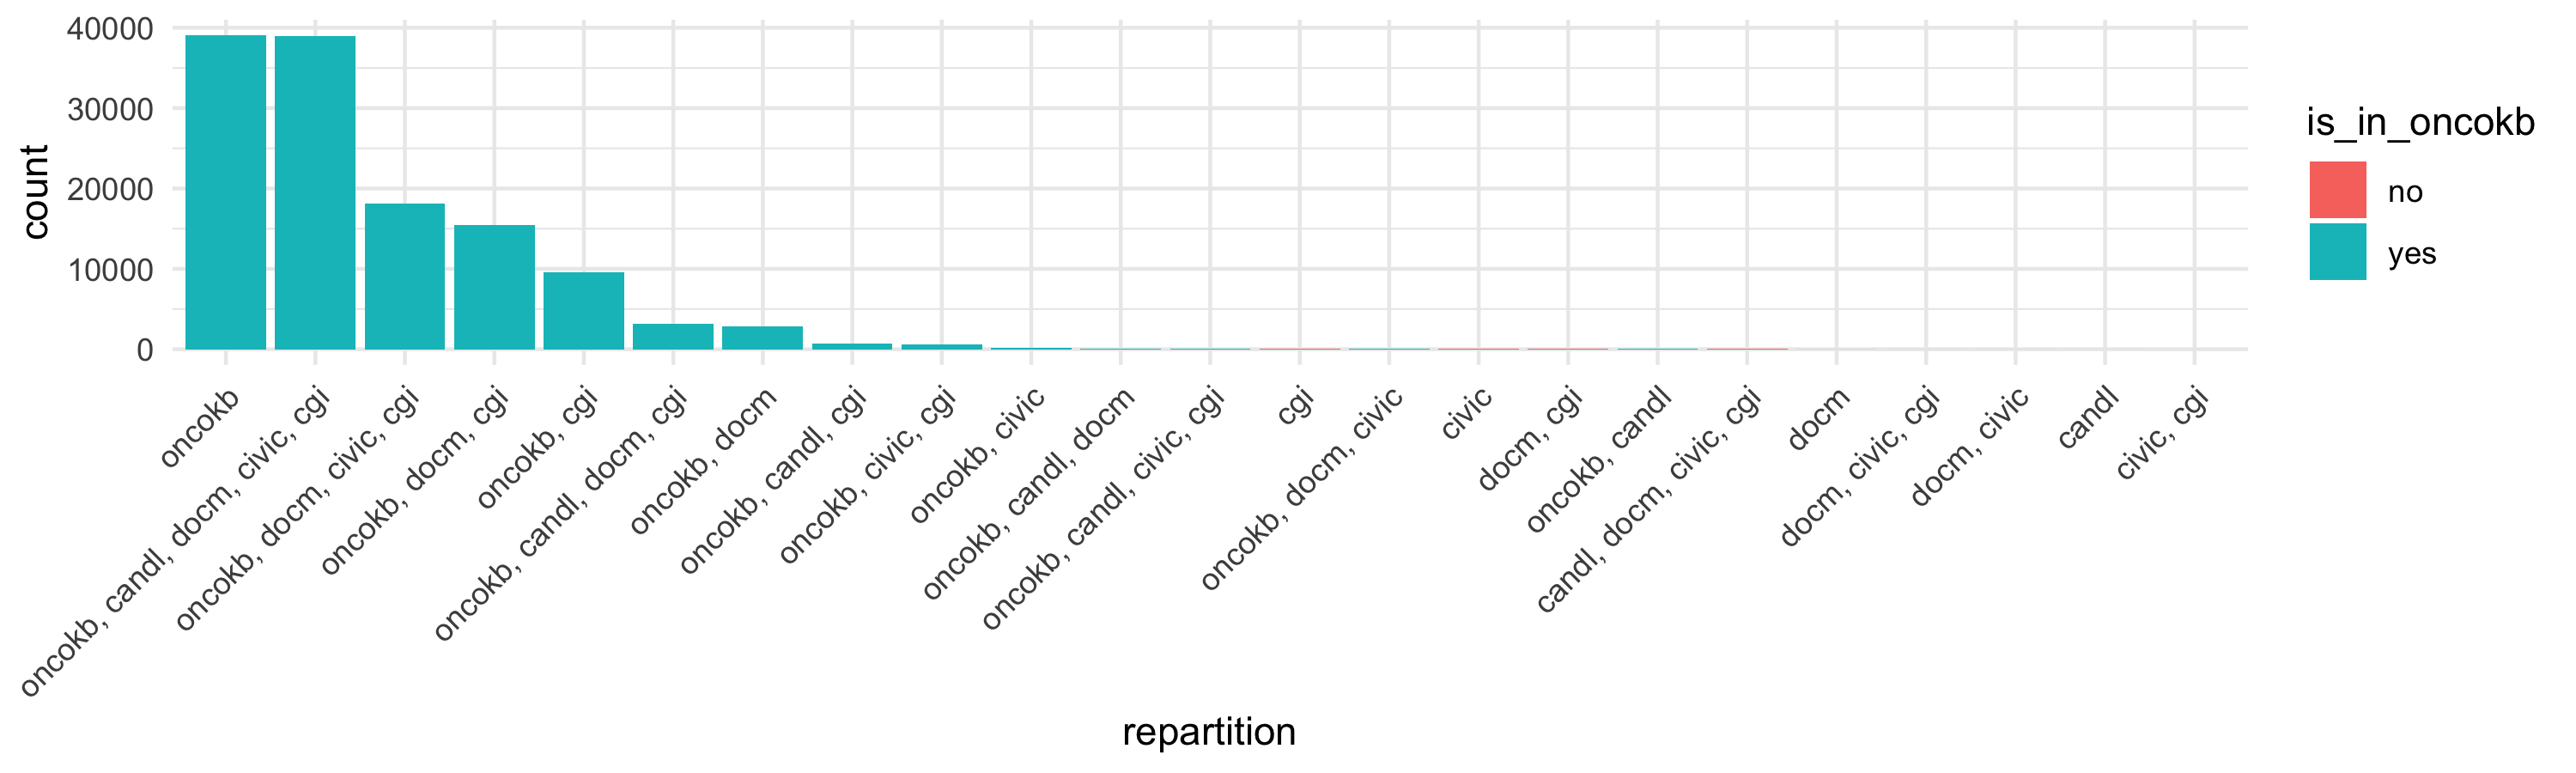

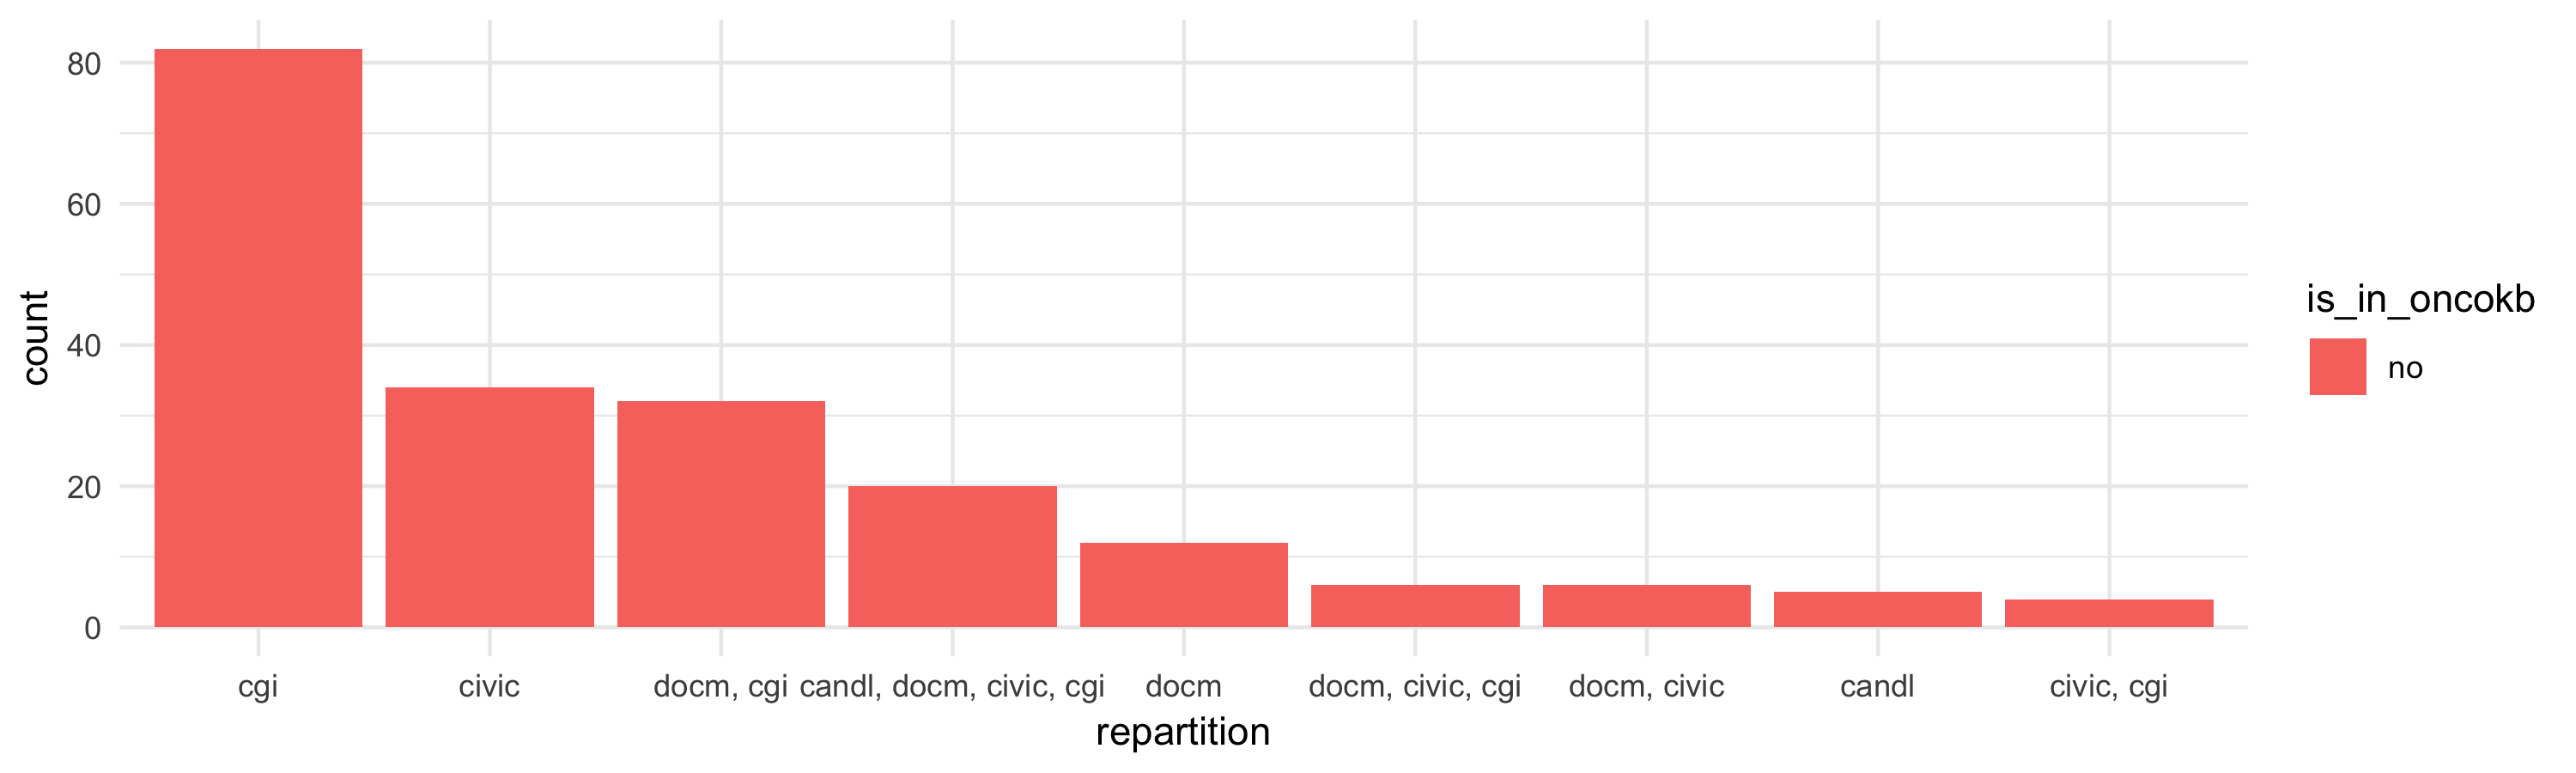

In [69]:
plot_histogram(annotated_mutations,
               "repartition", fill_name = "is_in_oncokb") + tilt_x_label_45()

plot_histogram(annotated_mutations[annotated_mutations$is_in_oncokb == "no",],
               "repartition", fill_name = "is_in_oncokb")

### At the key level

In [70]:
annotated_mutations_key <- as.data.frame(annotated_mutations %>% group_by(mut_key) %>%
                                                                 summarise(count = length(unique(database)),
                                                                           repartition = toString(unique(database)),
                                                                           is_in_oncokb = unique(is_in_oncokb)))

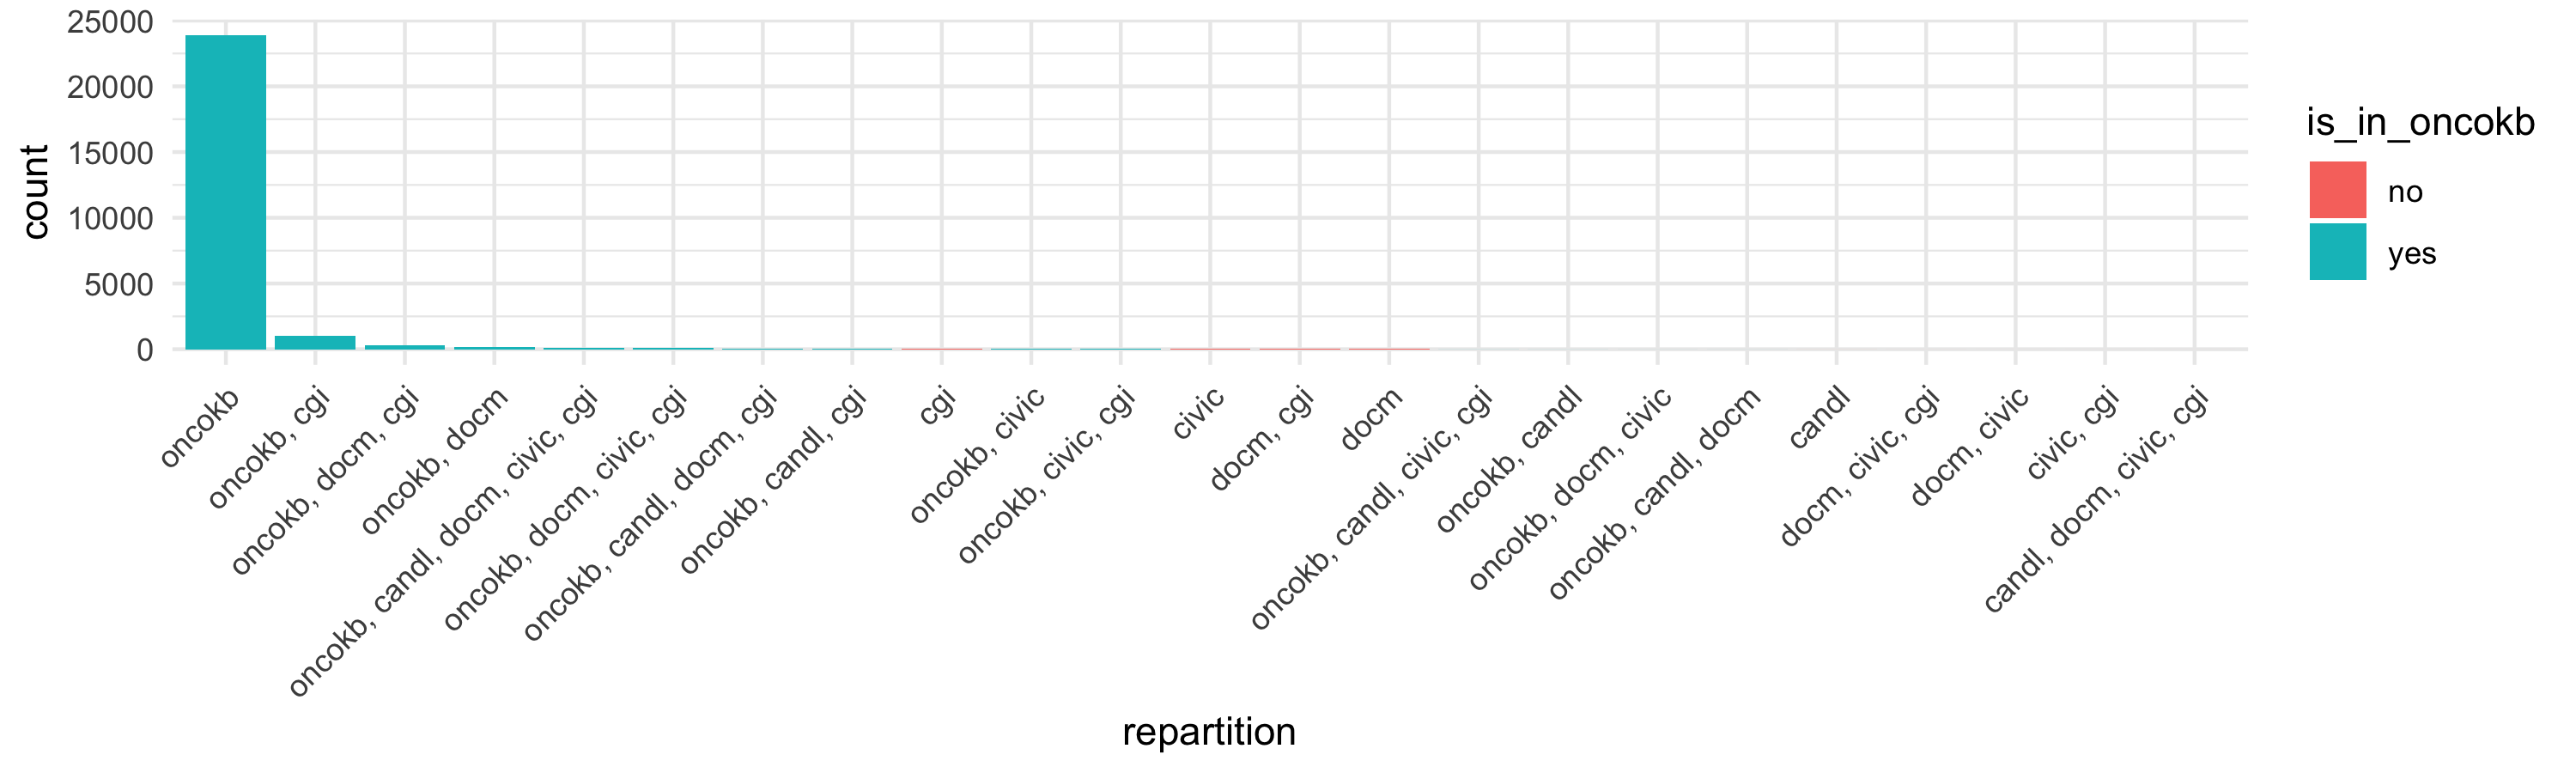

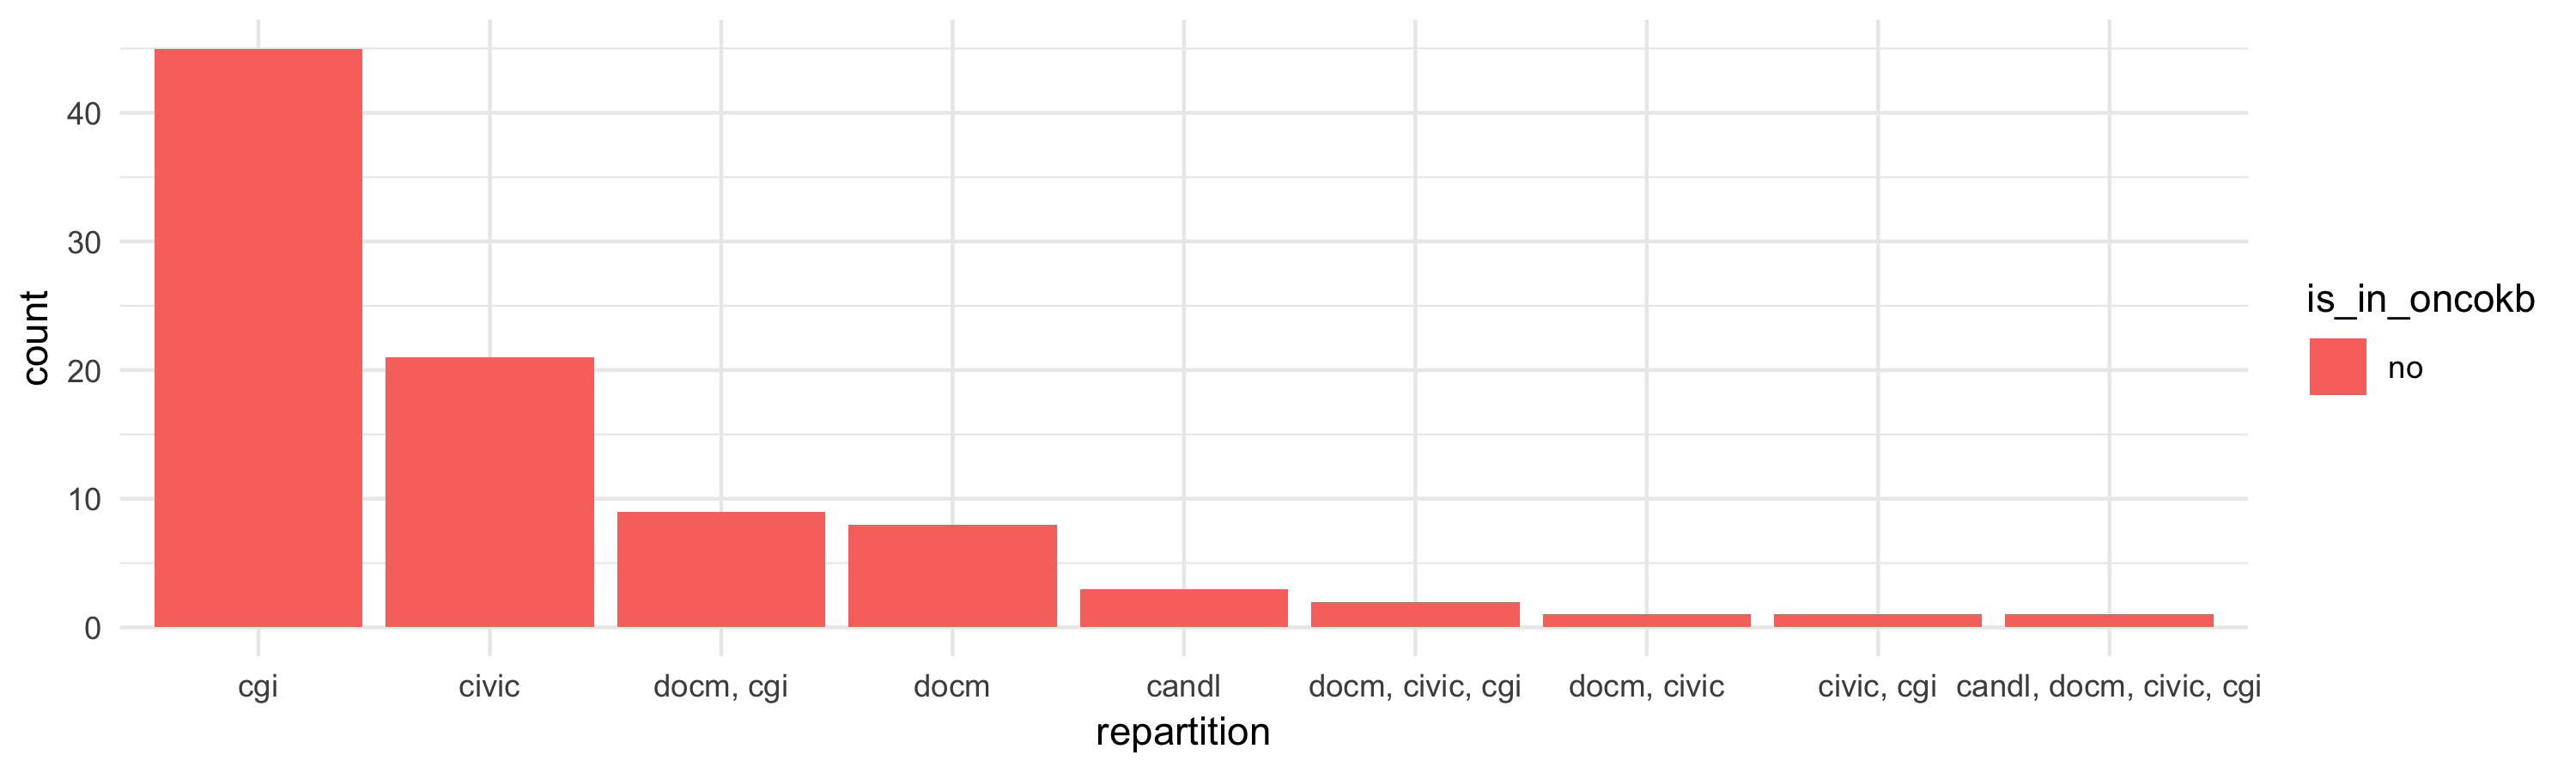

In [71]:
plot_histogram(annotated_mutations_key,
               "repartition", fill_name = "is_in_oncokb") + tilt_x_label_45()

plot_histogram(annotated_mutations_key[annotated_mutations_key$is_in_oncokb == "no",],
               "repartition", fill_name = "is_in_oncokb")

### Mutations not in OncoKB

In [72]:
# number of rows
nrow(annotated_mutations[annotated_mutations$is_in_oncokb == "no",])

# number of distinct mutations
length(unique(annotated_mutations$mut_key[annotated_mutations$is_in_oncokb == "no"]))

[1] 201

[1] 91

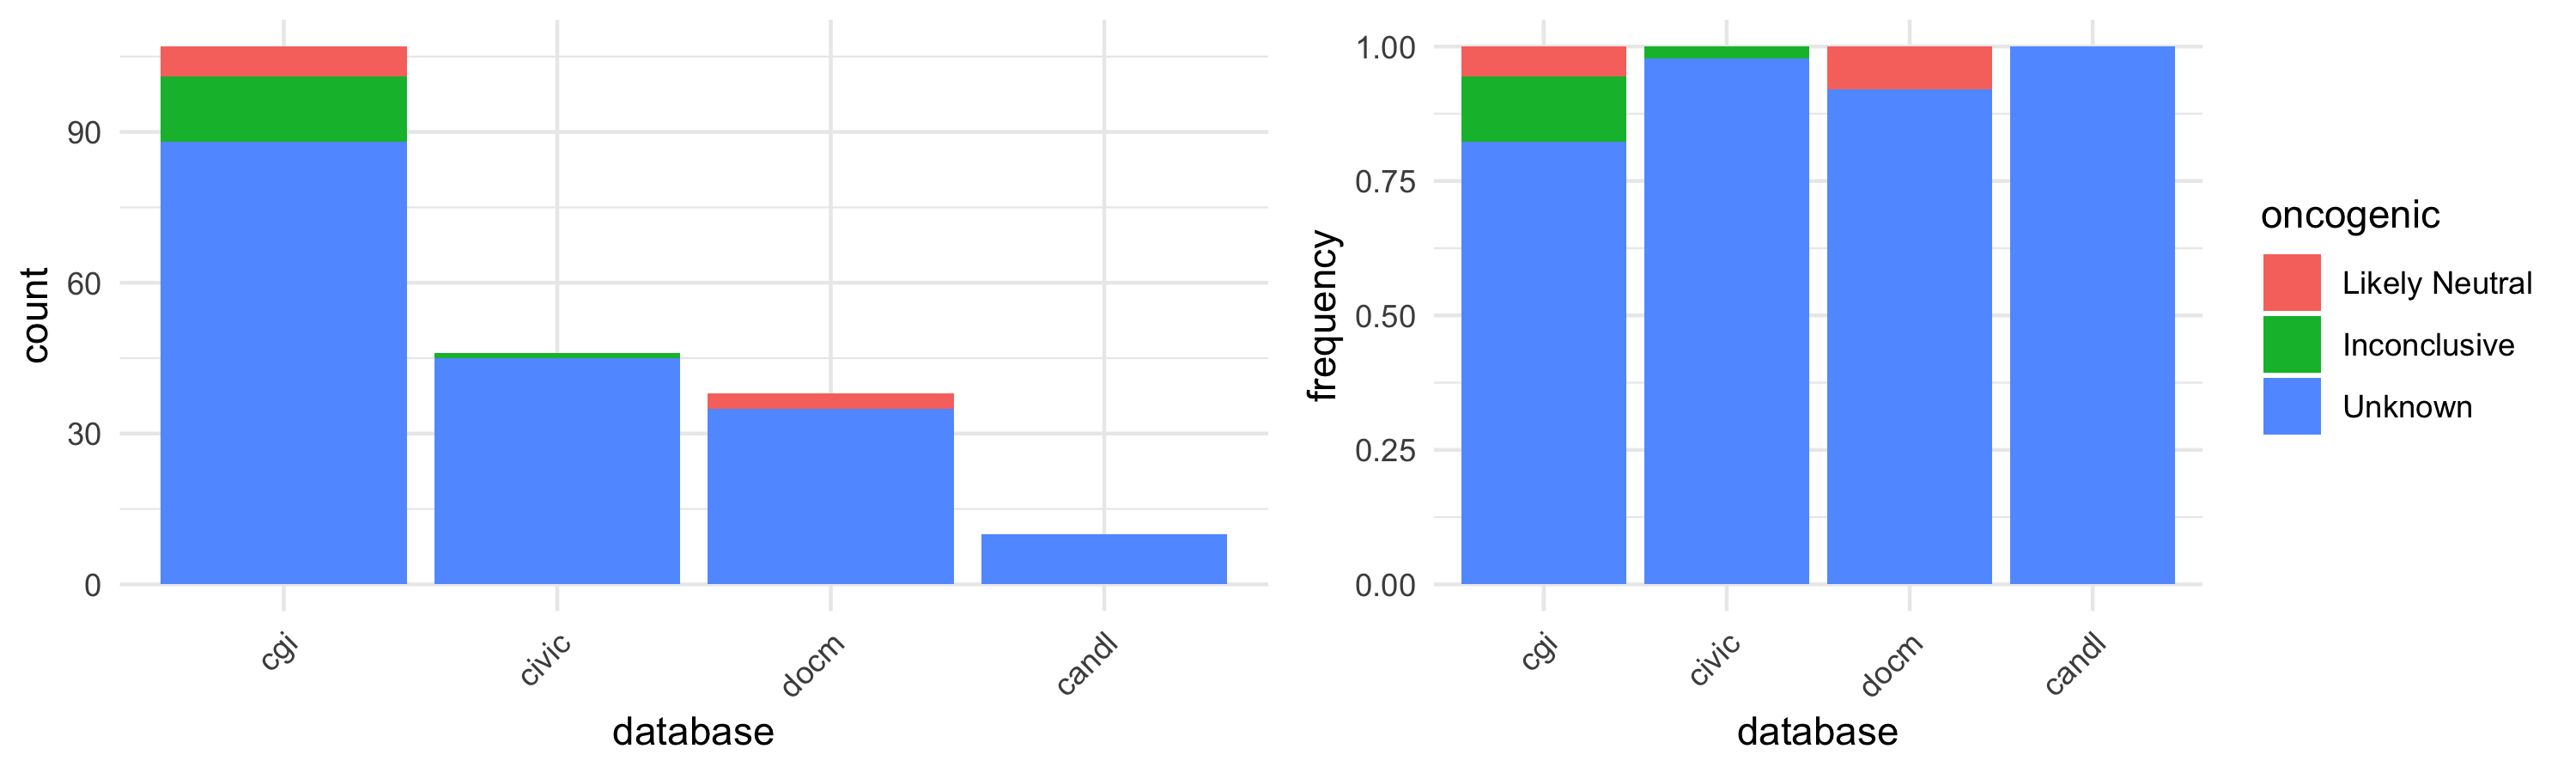

In [73]:
plot_contingency_table_as_histograms(annotated_mutations[annotated_mutations$is_in_oncokb == "no",], 
                                     "database", "oncogenic")

In [74]:
colnames = c("is_in_oncokb", "is_in_candl", "is_in_docm", "is_in_civic", "is_in_cgi")

table <- data.frame()

for (col in colnames) {
    table <- rbind(table, impact %>% filter(!! sym(col) == "yes") %>%
                                     summarise(oncokb = sum(is_in_oncokb == "yes"),
                                               candl  = sum(is_in_candl  == "yes"),
                                               docm   = sum(is_in_docm   == "yes"),
                                               civic  = sum(is_in_civic  == "yes"),
                                               cgi    = sum(is_in_cgi    == "yes")))
}

table <- as.table(as.matrix(table))
rownames(table) <- colnames(table)
table

       oncokb candl  docm civic   cgi
oncokb  64136  8867 19747 12629 23486
candl    8867  8877  8612  7818  8824
docm    19747  8612 19785 12351 18266
civic   12629  7818 12351 12675 12544
cgi     23486  8824 18266 12544 23593

In [76]:
table <- data.frame()

impact_by_key <- impact %>% group_by(mut_key) %>%
                            summarise(is_in_oncokb = unique(is_in_oncokb),
                                      is_in_candl  = unique(is_in_candl),
                                      is_in_docm   = unique(is_in_docm),
                                      is_in_civic  = unique(is_in_civic),
                                      is_in_cgi    = unique(is_in_cgi))

for (col in colnames) {
    table <- rbind(table, impact_by_key %>% filter(!! sym(col) == "yes") %>%
                                            summarise(oncokb = sum(is_in_oncokb == "yes"),
                                                      candl  = sum(is_in_candl  == "yes"),
                                                      docm   = sum(is_in_docm   == "yes"),
                                                      civic  = sum(is_in_civic  == "yes"),
                                                      cgi    = sum(is_in_cgi    == "yes")))
}

table <- as.table(as.matrix(table))
rownames(table) <- colnames(table)
table

       oncokb candl  docm civic   cgi
oncokb  25791   216   767   263  1662
candl     216   220   157    95   210
docm      767   157   788   182   576
civic     263    95   182   289   223
cgi      1662   210   576   223  1720

Why do we have so many OncoKB keys?

In [77]:
length(unique(impact$mut_key[impact$is_in_oncokb == "yes"]))
length(unique(impact$mut_key[impact$is_in_oncokb == "yes" & impact$Consequence %in% c("stopgain_SNV",
                                                                                      "frameshift_deletion",
                                                                                      "frameshift_insertion",
                                                                                      "splicing")]))

[1] 25791

[1] 21372

Most of them are truncating events.

## Study shared genes

VENN diagram

In [223]:
oncokb <- read.table("../../../data/other_databases/allAnnotatedVariants.txt",
                     sep = "\t", stringsAsFactors = FALSE, header = TRUE, fill = TRUE)

In [224]:
oncokb_genes <- unique(oncokb$Gene)
candl_genes  <- unique(candl$Gene)
docm_genes   <- unique(docm$gene)
civic_genes  <- unique(civic$gene)
cgi_genes    <- unique(cgi$gene)

### Correct Hugo symbols

In [225]:
candl_genes[! candl_genes %in% oncokb_genes]

[1] "CSF3R"  "FRK"    "LNK"    "LTK"    "PAK7"   "PRKACA" "ROCK1"  "TRRAP" 
[9] "TYK2"

|Old Hugo Symbol | New Hugo symbol | HGNC reason     |
| -------------- | --------------- | --------------- |
| PAK7           |  PAK5           | Previous symbol |
| LNK            |  SH2B3          | Synonyms        |
| 8528263"       |  -              | Unmatched       |
| 11726500"      |  -              | Unmatched       |
| 23816960"      |  -              | Unmatched       |
| 15118073"      |  -              | Unmatched       |
| 16187281"      |  -              | Unmatched       |
| 19718025"      |  -              | Unmatched       |
| 17699867"      |  -              | Unmatched       |
| 18955458"      |  -              | Unmatched       |
| 23582185"      |  -              | Unmatched       |
| 19075190"      |  -              | Unmatched       |
| 20570890"      |  -              | Unmatched       |
| 23970477"      |  -              | Unmatched       |
| 15928335"      |  -              | Unmatched       |
| 17376864"      |  -              | Unmatched       |
| 15647370"      |  -              | Unmatched       |

In [226]:
old_Hugo_Symbol = c('PAK7', 'LNK', '8528263\"', '11726500\"', '23816960\"', '15118073\"', '16187281\"', '19718025\"',
                    '17699867\"', '18955458\"', '23582185\"', '19075190\"', '20570890\"', '23970477\"', '15928335\"',
                    '17376864\"', '15647370\"')
new_Hugo_Symbol = c('PAK5', 'SH2B3', '-','-','-','-','-','-','-','-','-','-','-','-','-','-','-')

old_symbols <- which(candl_genes %in% old_Hugo_Symbol)
candl_genes[old_symbols] <- new_Hugo_Symbol[match(candl_genes[old_symbols], old_Hugo_Symbol)]

In [227]:
head(docm_genes[! docm_genes %in% oncokb_genes])

[1] "MTHFR"  "EPHA2"  "EPHB2"  "CSF3R"  "FCGR2A" "FCGR3A"

Every symbol approved.

In [228]:
head(civic_genes[! civic_genes %in% oncokb_genes])

[1] "NT5C2" "XRCC1" "ERCC5" "MTHFR" "GSTP1" "ABCG2"

Every symbol approved.

In [229]:
cgi_genes[! cgi_genes %in% oncokb_genes]

[1] "ABCB4"       "ARHGAP26"    "BAX"         "C15orf23"    "CASP10"     
 [6] "CRBN"        "CSF1R"       "CSF3R"       "DCC"         "DLC1"       
[11] "EIF2C2"      "EPHA2"       "EPHB2"       "FAM175A"     "FAS"        
[16] "FLCN"        "GATA1"       "GATA2"       "GJB2"        "GNAI2"      
[21] "GPC3"        "HERC2"       "IGF2R"       "ING1"        "IRF1"       
[26] "JAGN1"       "KCNJ5"       "KDM5C,KDM5C" "KLF6"        "LZTS1"      
[31] "MAD1L1"      "MCC"         "MLH3"        "MLL3"        "MRE11A"     
[36] "MUTYH"       "OGG1"        "OPCML"       "PDGFRL"      "PPARG"      
[41] "PRKAR1A"     "PTPN12"      "PTPRJ"       "RAD54B"      "RBBP8"      
[46] "RECQL4"      "RNF6"        "SDHA"        "SDHAF2"      "SDHD"       
[51] "SLC22A18"    "TMEM127"     "WRN"         "WT1"         "WWOX"       
[56] "XPC"

|Old Hugo Symbol | New Hugo symbol | HGNC reason     |
| -------------- | --------------- | --------------- |
| C15orf23       |  KNSTRN         | Previous symbol |
| EIF2C2         |  AGO2           | Previous symbol |
| FAM175A        |  ABRAXAS1       | Previous symbol |
| MLL3           |  KMT2C          | Previous symbol |
| MRE11A         |  MRE11          | Previous symbol |

In [230]:
old_Hugo_Symbol = c('C15orf23', 'EIF2C2', 'FAM175A', 'MLL3', 'MRE11A')
new_Hugo_Symbol = c('KNSTRN', 'AGO2', 'ABRAXAS1', 'KMT2C', 'MRE11')

old_symbols <- which(cgi_genes %in% old_Hugo_Symbol)
cgi_genes[old_symbols] <- new_Hugo_Symbol[match(cgi_genes[old_symbols], old_Hugo_Symbol)]

### Study genes sharing

In [66]:
oncokb_genes <- as.data.frame(unique(oncokb$Gene))
candl_genes  <- as.data.frame(unique(candl$Gene))
docm_genes   <- as.data.frame(unique(docm$gene))
civic_genes  <- as.data.frame(unique(civic$gene))
cgi_genes    <- as.data.frame(unique(cgi$gene))

colnames(oncokb_genes) <- "gene"
colnames(candl_genes)  <- "gene"
colnames(docm_genes)  <- "gene"
colnames(civic_genes)  <- "gene"
colnames(cgi_genes)    <- "gene"

oncokb_genes$database <- "oncokb"
candl_genes$database  <- "candl"
docm_genes$database   <- "docm"
civic_genes$database  <- "civic"
cgi_genes$database    <- "cgi"

annotated_genes <- rbind(oncokb_genes, candl_genes, docm_genes, civic_genes, cgi_genes)

In [67]:
annotated_genes <- as.data.frame(annotated_genes %>% group_by(gene) %>%
                                                     summarise(count = length(unique(database)),
                                                               repartition = toString(unique(database)),
                                                               in_onco_kb = grepl("oncokb", repartition)))

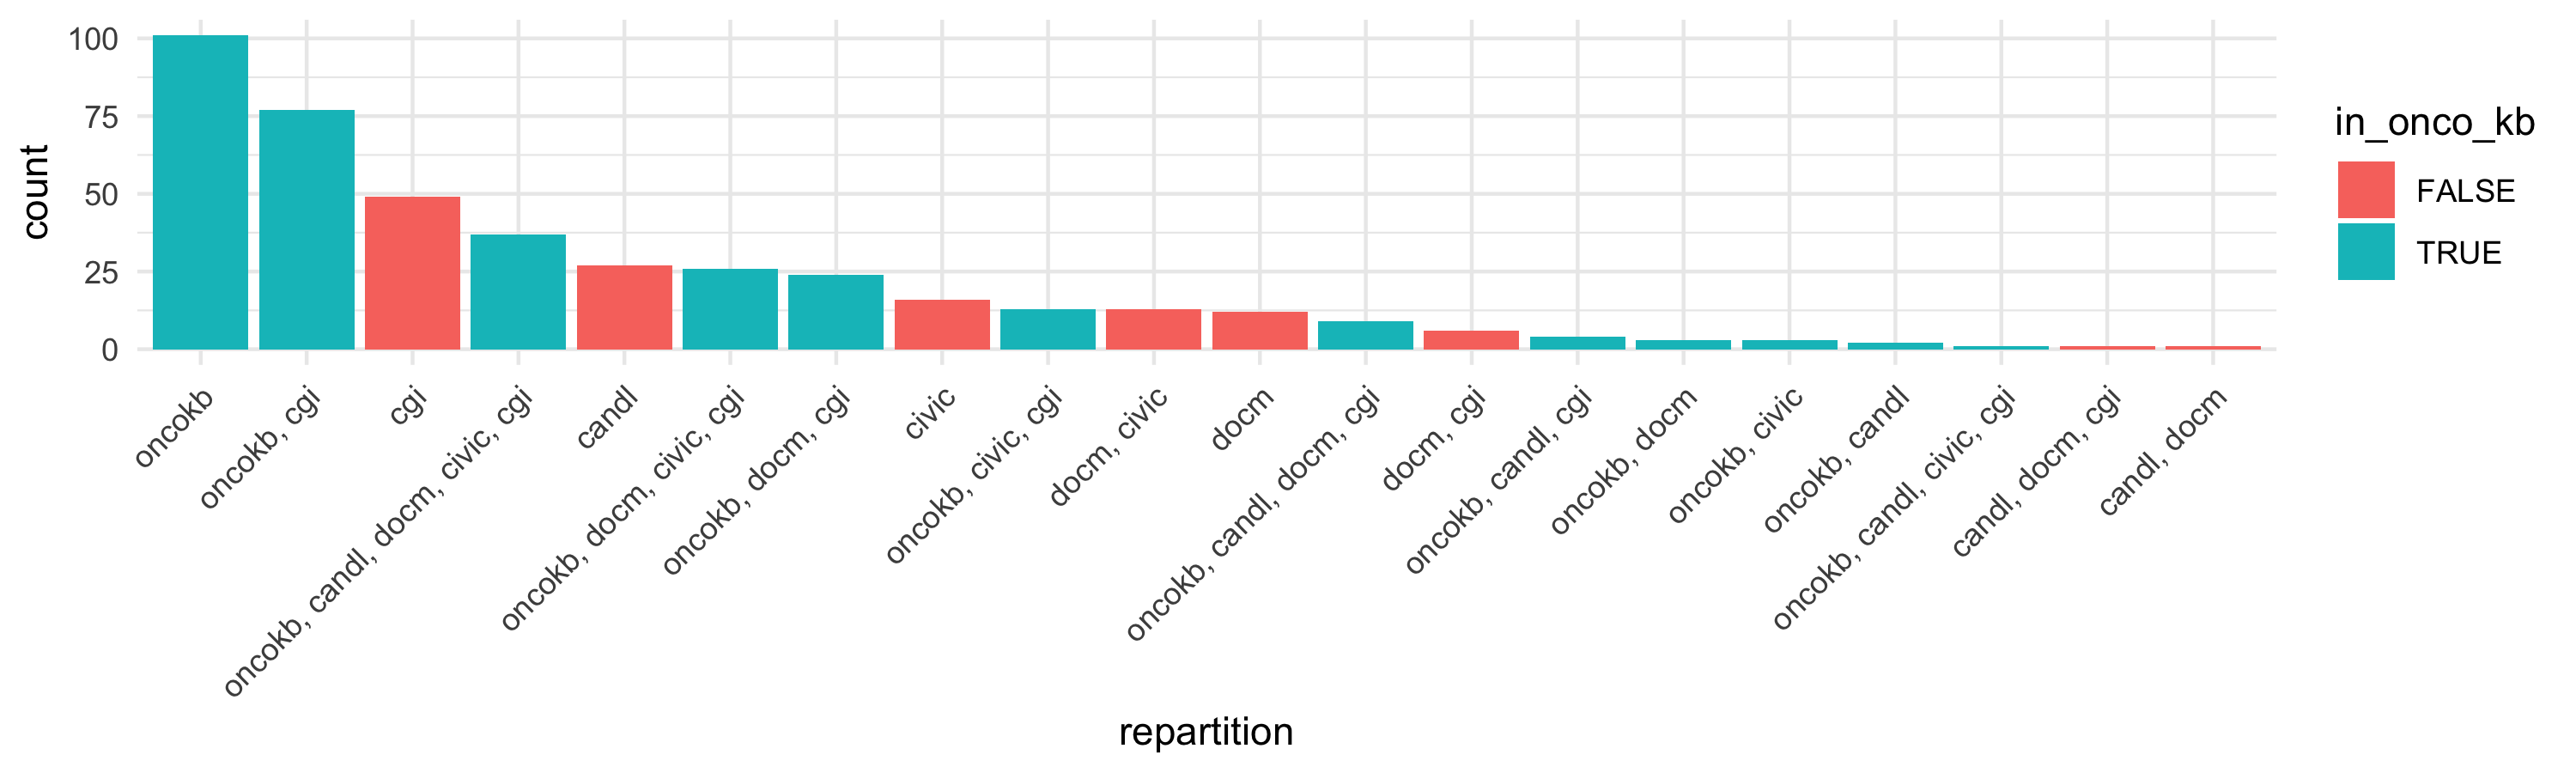

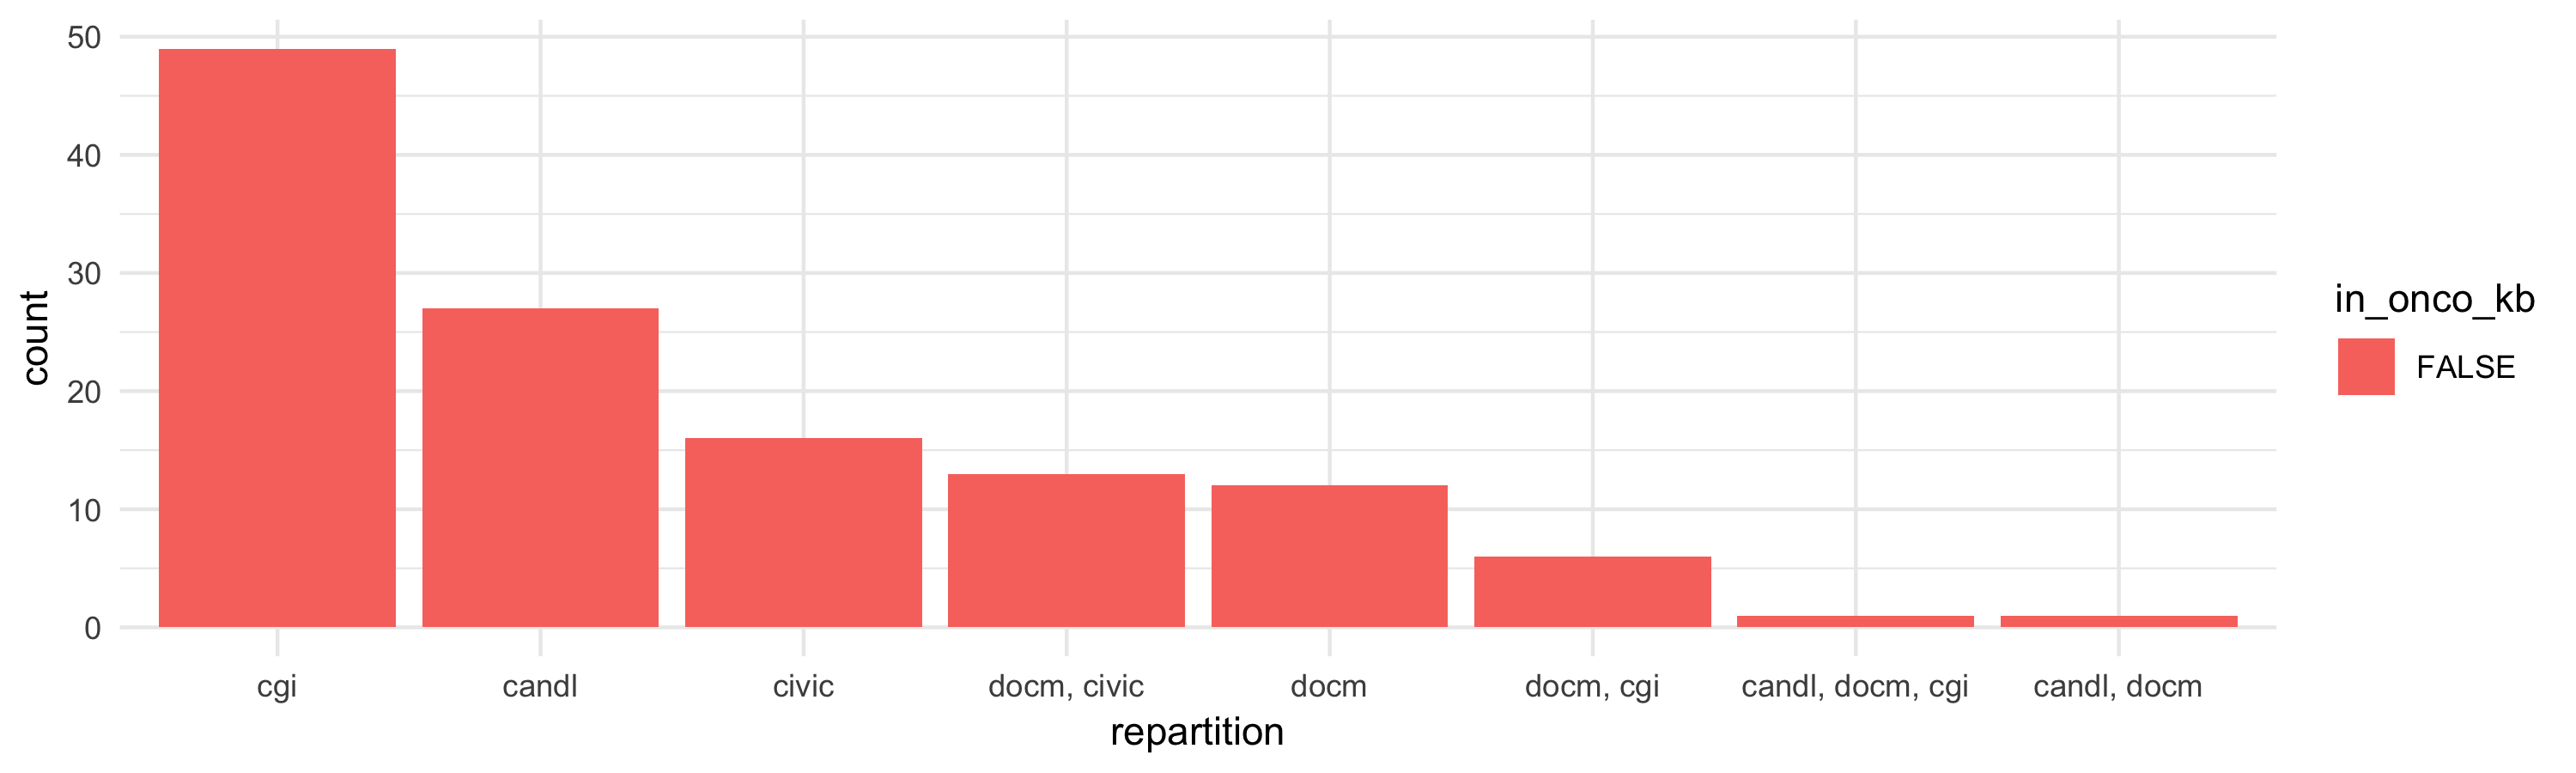

In [68]:
plot_histogram(annotated_genes,
               "repartition", fill = "in_onco_kb") + tilt_x_label_45()
plot_histogram(annotated_genes[! annotated_genes$in_onco_kb,],
               "repartition", fill = "in_onco_kb")

In [69]:
as.character(annotated_genes$gene[annotated_genes$count == 5])

table(annotated_genes$repartition[annotated_genes$count == 4])
as.character(annotated_genes$gene[annotated_genes$count == 4])

table(annotated_genes$repartition[annotated_genes$count == 3])
as.character(annotated_genes$gene[annotated_genes$count == 3])

table(annotated_genes$repartition[annotated_genes$count == 2])
as.character(annotated_genes$gene[annotated_genes$count == 2])

[1] "ABL1"   "AKT1"   "ALK"    "ARAF"   "BRAF"   "BTK"    "CDK4"   "DDR2"  
 [9] "EGFR"   "ERBB2"  "ERBB3"  "ERBB4"  "ESR1"   "FGFR2"  "FGFR3"  "FLT3"  
[17] "GNAQ"   "GNAS"   "IDH1"   "IDH2"   "JAK1"   "JAK2"   "JAK3"   "KDR"   
[25] "KIT"    "KRAS"   "MAP2K1" "MAP2K2" "MET"    "MTOR"   "MYD88"  "NRAS"  
[33] "PDGFRA" "PIK3CA" "RAC1"   "RET"    "SMO"


oncokb, candl, civic, cgi  oncokb, candl, docm, cgi  oncokb, docm, civic, cgi 
                        1                         9                        26 

[1] "AKT3"   "AR"     "ATM"    "B2M"    "BRCA1"  "CDKN2A" "CHEK2"  "CTNNB1"
 [9] "DNMT3A" "ERCC2"  "EZH2"   "FGFR1"  "FGFR4"  "FOXL2"  "GNA11"  "HRAS"  
[17] "IL7R"   "MAPK1"  "MLH1"   "MYC"    "NOTCH1" "NPM1"   "PIK3R1" "PTEN"  
[25] "PTPN11" "RAF1"   "RB1"    "RHOA"   "ROS1"   "RUNX1"  "SF3B1"  "STK11" 
[33] "TP53"   "TSC2"   "U2AF1"  "VHL"


  candl, docm, cgi oncokb, candl, cgi oncokb, civic, cgi  oncokb, docm, cgi 
                 1                  4                 13                 24 

[1] "ACVR1"   "AKT2"    "APC"     "BRCA2"   "CARD11"  "CBL"     "CCND3"  
 [8] "CREBBP"  "CRLF2"   "EP300"   "ETV6"    "FANCA"   "FBXW7"   "H3F3A"  
[15] "MED12"   "MEN1"    "MPL"     "MSH2"    "MSH6"    "MYCN"    "NF2"    
[22] "NFE2L2"  "NTRK3"   "PIK3R2"  "PLCG2"   "PMS2"    "POLE"    "PPP2R1A"
[29] "PPP6C"   "PTPRD"   "RAD51D"  "RHEB"    "RIT1"    "SMAD4"   "SOS1"   
[36] "SPOP"    "SRC"     "STAT3"   "TERT"    "TSC1"    "XPO1"    "CSF3R"


  candl, docm     docm, cgi   docm, civic oncokb, candl   oncokb, cgi 
            1             6            13             2            77 
oncokb, civic  oncokb, docm 
            3             3 

[1] "ATR"      "AURKA"    "AXIN2"    "BAP1"     "BARD1"    "BCL10"   
  [7] "BCL2"     "BLM"      "BMPR1A"   "BRIP1"    "CASP8"    "CCND1"   
 [13] "CDC73"    "CDH1"     "CDK12"    "CDK6"     "CDKN1B"   "CDKN2B"  
 [19] "CEBPA"    "CTCF"     "CTLA4"    "CYSLTR2"  "DICER1"   "DIS3"    
 [25] "ELF3"     "EPAS1"    "ERCC3"    "ERCC4"    "ERRFI1"   "FANCC"   
 [31] "FAT1"     "FH"       "FOXA1"    "FOXO1"    "FOXP1"    "GLI1"    
 [37] "HIST1H1C" "HNF1A"    "IGF1R"    "KDM5C"    "KEAP1"    "KLF4"    
 [43] "KNSTRN"   "MAP2K4"   "MAX"      "MDM2"     "MDM4"     "MEF2B"   
 [49] "MITF"     "MYOD1"    "NBN"      "NF1"      "NTRK1"    "NUP93"   
 [55] "PALB2"    "PDGFRB"   "PIK3CB"   "PIK3CD"   "PIM1"     "PMS1"    
 [61] "PTCH1"    "PTPRT"    "RAB35"    "RAD50"    "RAD51C"   "RAD54L"  
 [67] "RASA1"    "RRAS2"    "RXRA"     "SDHB"     "SDHC"     "SETD2"   
 [73] "SHOC2"    "SMAD2"    "SMAD3"    "SMARCA4"  "SOX9"     "SRSF2"   
 [79] "STAT5B"   "TCF3"     "TET2"     "TGFBR1"   "TGFBR2"   "WHSC1"   
 [85] "XRCC2"    "ROCK1"    "ABCB1"    "ABCG2"    "CSF1R"    "EPHA2"   
 [91] "EPHB2"    "ETS2"     "FCGR2A"   "FCGR3A"   "GATA2"    "GSTP1"   
 [97] "HERC2"    "MGMT"     "MTHFR"    "NQO1"     "NT5C2"    "PML"     
[103] "SETBP1"   "WT1"      "XRCC1"